# Supporting Material for "Deep Learning Super-Resolution Network Facilitating Fiducial Tangibles on Capacitive Touchscreens"

## Install and import packages

In [1]:
import gc
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
from IPython.display import HTML, display
import IPython.display
from matplotlib import animation, rc
import matplotlib.image as mpimg
import numpy as np
from functools import reduce
import itertools
import pickle
import pandas as pd
from ast import literal_eval
from scipy.spatial.transform import Rotation as R
import skimage
from skimage import measure
from sklearn import preprocessing
import os
import math
import json
import shutil
import datetime
import cv2
import dt_apriltags
from cv2 import aruco
import time
import sys
from tqdm import tqdm
tqdm.pandas()
from io import StringIO
import sklearn.metrics
import scipy
from glob import glob
import imutils
import tensorflow as tf
print("tf:", tf.__version__)
from tensorflow.keras import datasets, layers, models
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.python.framework import ops

# if available (Linux)
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')
# check $nvtop in console to determine which GPU is better at the moment
tf.config.experimental.set_memory_growth(physical_devices[1], True)

tf: 2.9.1
INFO: Pandarallel will run on 56 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Preprocess data


### Define functions


#### Loading

In [2]:
def read_capa_file(filepath, flip= False):
    with open(filepath, 'r', encoding='utf8') as file:
        data = file.read().split('\n')
    # discard the last entries since they are invalid
    json_str = ",".join(data[:-2])

    try:
        data = json.loads(f"[ {json_str} ]")
    except Exception as e:
        print(f"Failed to load JSON: {e}")

    df_capa = pd.DataFrame(data)
    df_capa = df_capa.rename(columns={"matrix": "Matrix", "timeStamp": "TimeStampUnix"})
    # divide by 1000 to get the standard formal (s.ms)
    df_capa.TimeStampUnix = df_capa.TimeStampUnix / 1000
    # sort by time (should already be sorted)
    df_capa = df_capa.sort_values("TimeStampUnix") 

    # convert to float32 and assign correct sensor shape
    df_capa.Matrix = df_capa.Matrix.apply(lambda x: np.array(x).clip(0, 255))
    df_capa.Matrix = df_capa.Matrix.apply(lambda x: x.astype(np.ubyte))
    df_capa.Matrix = df_capa.Matrix.apply(lambda x: x.reshape(CAPA_SHAPE))
    if flip:
        df_capa.Matrix = df_capa.Matrix.apply(lambda x: np.fliplr(x))
      
    return df_capa

In [42]:
def read_opti_file(filepath, timeshift= 0.0, df_capa_sync = pd.DataFrame(), capa_tolerance= 0.02, opti_tolerance= 20.0, plot_sync= False):
    with open(filepath, 'r', encoding='utf8') as file:
        line = file.readline()
        time_string = line.split(',')[11]
    
    # retrieve datetime and fix 12AM error of motive
    dt = datetime.datetime.strptime(time_string, '%Y-%m-%d %I.%M.%S.%f %p')
    if dt.hour == 0 and dt.strftime("%p") == "AM":
        dt = dt.replace(hour=12)
    t_adjusted = dt.replace(tzinfo=datetime.timezone(datetime.timedelta(hours=1))).timestamp()

    # discard the first rows to get a well-formed csv
    df_opti = pd.read_csv(filepath, skiprows=list(range(6)))
    df_opti = df_opti.filter(["Time (Seconds)","X","Y","Z","W","X.1","Y.1","Z.1"], axis=1)
    # some rows might be NaN due to obstructed markers
    df_opti = df_opti.dropna()
    df_opti = df_opti.reset_index(drop=True)

    # calculate euler rotation; get the y value 
    quat = df_opti[["X", "Y", "Z", "W"]].values
    rot = R.from_quat(quat)
    euler = rot.as_euler('yzx', degrees=True)
    df_opti['Angle'] = euler[:,0]
    df_opti['Angle'] = df_opti.Angle.astype(np.float64)
    # Rotation from 0 - 359
    df_opti['Angle'] = (df_opti.Angle + 360.0) % 360.0
    
    df_opti = df_opti.rename(columns={"Time (Seconds)": "TimeStampUnix",
                                    "X": "Rotation_X", "Y": "Rotation_Y", "Z": "Rotation_Z",  "W": "Rotation_W", 
                                    "X.1": "Position_X", "Y.1": "Position_Y", "Z.1": "Position_Z"})
    
    # convert to unit mm
    df_opti.Position_X = df_opti.Position_X.multiply(1000)
    df_opti.Position_Y = df_opti.Position_Y.multiply(1000)
    df_opti.Position_Z = df_opti.Position_Z.multiply(1000)

    # adjust to synchronized Unix time
    df_opti.TimeStampUnix = df_opti.TimeStampUnix + t_adjusted + timeshift

    # fix time error
    if not df_capa_sync.empty:
        scaling = 0.05

        sums = df_capa_sync.Matrix.apply(lambda x: np.sum(x*scaling))
        capa_mean = np.mean(sums)

        # find the first occurance of the capacitive marker
        capa_ts = next(df_capa_sync.iloc[i].TimeStampUnix for i,x in enumerate(sums) if x >= capa_mean*capa_tolerance)
        dydx = np.diff(df_opti.Position_Y)/np.diff(df_opti.TimeStampUnix)

        # find the first occurance of the zero opti derivative
        opti_ts = next(df_opti.iloc[i].TimeStampUnix for i,x in enumerate(dydx) if np.abs(x) <= opti_tolerance)

        time_error = opti_ts - capa_ts

        # fix one hour shifts
        if time_error < -3500:
            timeshift = 60*60
            return read_opti_file(filepath, timeshift, df_capa_sync, capa_tolerance, opti_tolerance, plot_sync)
        elif time_error > 3500:
            timeshift = -60*60
            return read_opti_file(filepath, timeshift, df_capa_sync, capa_tolerance, opti_tolerance, plot_sync)

        df_opti.TimeStampUnix -= time_error
      
        if plot_sync:
            fig, ax = plt.subplots()
            ax.plot(df_capa_sync.TimeStampUnix, sums, c="red", alpha=0.5, label="Capa sum")
            ax.plot(df_opti.TimeStampUnix[1:], dydx, c="blue", alpha=0.5, label="Opti f'(y)")

            ax.scatter(capa_ts, 0, s=30, c="red", alpha=0.5, label="Capa ts")
            ax.scatter(opti_ts, 0, s=30, c="blue", alpha=0.5, label="Opti ts")

            ax.set_title(f"Time Error: {np.round(time_error,3)} sec")
            ax.set_xlim(opti_ts - 2, opti_ts + 5)
            plt.legend()
            plt.show()
        else:
            print(f"Time Error: {np.round(time_error,3)} sec")

    return df_opti, time_error

#### Blobs

In [4]:
def get_norm(e):
    e = e.copy()
    e[e<0.0] = 0.0
    normalizedImg = e.copy()#np.empty(e.shape, np.float32)
    cv2.normalize(e,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    return normalizedImg

In [5]:
def detect_blobs(image, min_cutoff = 20, blob_threshold = 220):
    lstBlob  = []
    lstMin = []
    lstMax = []
    lstMean = []
    lstXY = []
    
    image = image.clip(0,255)    
    if np.any(image > min_cutoff):
        image = get_norm(image).clip(0,255).astype(np.uint8)
        large = np.pad(image, 1)
        temp, thresh = cv2.threshold(cv2.bitwise_not(large), blob_threshold, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = [a for a in contours if cv2.contourArea(a) > 2 and cv2.contourArea(a) < ((large.shape[0]-1) * (large.shape[1]-1))]
        
        contours.sort(key = lambda a: cv2.contourArea(a))
        for max_contour in contours:
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            xmax, ymax = min(xmax + 1, large.shape[1]), min(ymax + 1, large.shape[0])
            xmin, ymin = max(xmin, 0), max(ymin, 0)
            blob = large[ymin:ymax,xmin:xmax].astype(np.ubyte)
            
            M = cv2.moments(max_contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])          
            
            lstBlob.append(blob)
            lstMin.append(xmax-xmin)
            lstMax.append(ymax-ymin)
            lstXY.append([cX, cY])
        return lstBlob, lstMin, lstMax, lstXY
    else:
        return [], [], [], []

In [6]:
def add_blobs(df, matrix_col, cutoff = 5, threshold = 220, max_size = 20):
    blob = []
    blob_w = []
    blob_h = []
    blob_x = []
    blob_y = []

    def get_blob(matrix):
        b, w, h, xy = detect_blobs(matrix, cutoff, threshold)

        # catch failed blob detection
        if len(b) == 0 or w[-1] > max_size or h[-1] > max_size:
            blob.append(np.NaN)
            blob_w.append(np.NaN)
            blob_h.append(np.NaN)
            blob_x.append(np.NaN)
            blob_y.append(np.NaN)
        else:
            blob.append(b[-1])
            blob_w.append(w[-1])
            blob_h.append(h[-1])
            blob_x.append(xy[-1][0])
            blob_y.append(xy[-1][1])

    df[matrix_col].apply(lambda x: get_blob(x)).values

    df["Blob"] = blob
    df["Blob_W"] = blob_w
    df["Blob_H"] = blob_h
    df["Blob_X"] = blob_x
    df["Blob_Y"] = blob_y

    # clean and parse
    df = df.dropna()
    df = df.reset_index(drop=True)
    df.Blob = df.Blob.apply(lambda x: x.astype(np.ubyte))
    df.Blob_W = df.Blob_W.astype(int)
    df.Blob_H = df.Blob_H.astype(int)
    df.Blob_X = df.Blob_X.astype(int)
    df.Blob_Y = df.Blob_Y.astype(int)

    return df

In [7]:
def pad_and_center(df, fill_sizes):
    # fill matrices
    for i, suffix in enumerate(["small", "large"]):
        fill_blob = []
        for j, row in tqdm(df.iterrows(), total=df.shape[0]):
            fill_matrix = np.zeros(fill_sizes[i], dtype=np.ubyte)      
            # (pad_mid - blob_size) / 2
            fill_matrix[int((fill_sizes[i][0] - row[f"Blob_H_{suffix}"]) / 2) : 
                                    int((fill_sizes[i][0] - row[f"Blob_H_{suffix}"]) / 2) + int(row[f"Blob_H_{suffix}"]),
                                    int((fill_sizes[i][1] - row[f"Blob_W_{suffix}"]) / 2) :
                                    int((fill_sizes[i][1] - row[f"Blob_W_{suffix}"]) / 2) + int(row[f"Blob_W_{suffix}"])] += row[f"Blob_{suffix}"]
            fill_blob.append(fill_matrix)
        df[f"Fill_Blob_{suffix}"] = fill_blob
        df[f"Fill_Blob_{suffix}"] = df[f"Fill_Blob_{suffix}"].apply(lambda x: x.astype(np.ubyte))

    return df

#### Misc

In [8]:
def rotate_image(image, angle):
    if angle == 0 or angle == 360:
            return image
    if angle == 90:
        result = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 180:
        temp = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        result = cv2.rotate(temp, cv2.ROTATE_90_CLOCKWISE)
    elif angle == 270:
        result = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    result = result.astype(np.ubyte)
    return result

In [9]:
def progress(value, max=100):
    """ Visualizes loop progress via HTML5
    """
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'>
            {value}
        </progress>
    """.format(value=value, max=max))

## Load data

The first step is to load the capacitive images and generate DataFrames. We do this for all specified `IDs` (touples of id and size) and save the DataFrames in the list `capa_data`.

In [74]:
# shape of the raw capacitive images
CAPA_SHAPE = (49,37)

# the AprilTag IDs to process: ([ids], [sizes]) e.g. ([1,2,3], [4,12])
#IDs = [([1, 2, 4, 7, 15, 29, 30, 33, 47, 54, "0t", "2t", "3t", "1a", "4a", "10a", "6k", "12k", "15k"], [4, 8]), 
#       ([1, 2, 4, 7, 15, 29, 30, 33, 47, 54, "0t", "2t", "3t", "1a", "4a", "10a", "6k", "12k", "15k"], [6, 12])]

# Small extract for playing around
IDs = [([1, 2, 47, "0t", "1a", "6k"], [4, 8]), 
       ([1, 2, 47, "0t", "1a", "6k"], [6, 12])]

# output shapes of the small and large matrices
SMALL_SHAPE = (30,30)
LARGE_SHAPE = (60,60)

# permute IDs
perm_ids = []
for i, id in enumerate(IDs):
      perm_ids.append(np.asarray(list(itertools.product(IDs[i][0], IDs[i][1]))).reshape((len(IDs[i][0]), len(IDs[i][1]), 2)).tolist())
print(f"Permutated IDs: {perm_ids}")

Permutated IDs: [[[['1', '4'], ['1', '8']], [['2', '4'], ['2', '8']], [['47', '4'], ['47', '8']], [['0t', '4'], ['0t', '8']], [['1a', '4'], ['1a', '8']], [['6k', '4'], ['6k', '8']]], [[['1', '6'], ['1', '12']], [['2', '6'], ['2', '12']], [['47', '6'], ['47', '12']], [['0t', '6'], ['0t', '12']], [['1a', '6'], ['1a', '12']], [['6k', '6'], ['6k', '12']]]]


In [75]:
capa_data = []
mean_capa = []

for group in perm_ids:
    group_data = []
    for ids in group:
        id_data = []
        for (id, size) in ids:
            df_capa = read_capa_file(f"./Data/Capacitive/id{id}_{size}mm.json", flip= True)
            print(f"ID {id}, size {size}: {df_capa.shape}")
            mean_capa.append(df_capa.shape[0])
            id_data.append(df_capa)
        group_data.append(id_data)
    capa_data.append(group_data)
capa_data = np.asarray(capa_data, dtype=object)

print(f"Dataset: {capa_data.shape}, mean: {int(np.mean(mean_capa))} (SD: {int(np.std(mean_capa))})")

ID 1, size 4: (4263, 2)
ID 1, size 8: (4149, 2)
ID 2, size 4: (4215, 2)
ID 2, size 8: (4184, 2)
ID 47, size 4: (4240, 2)
ID 47, size 8: (4164, 2)
ID 0t, size 4: (4229, 2)
ID 0t, size 8: (4326, 2)
ID 1a, size 4: (4350, 2)
ID 1a, size 8: (4064, 2)
ID 6k, size 4: (4002, 2)
ID 6k, size 8: (3986, 2)
ID 1, size 6: (4164, 2)
ID 1, size 12: (3989, 2)
ID 2, size 6: (4209, 2)
ID 2, size 12: (4041, 2)
ID 47, size 6: (4227, 2)
ID 47, size 12: (3977, 2)
ID 0t, size 6: (4255, 2)
ID 0t, size 12: (4178, 2)
ID 1a, size 6: (4277, 2)
ID 1a, size 12: (3970, 2)
ID 6k, size 6: (4107, 2)
ID 6k, size 12: (3933, 2)
Dataset: (2, 6, 2), mean: 4145 (SD: 120)


We can visualize the raw capacitive images.

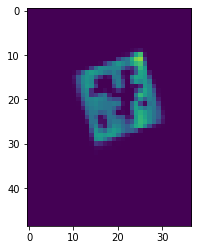

In [141]:
plt.imshow(capa_data[0,0,1].Matrix.iloc[100], vmin = 0, vmax = 255)

The next step is to load the OptiTrack data and synchronize it to the Unix time of the corresponding capacitive data. We do this for all specified `IDs` and save the resulting DataFrames in the list `opti_data`.

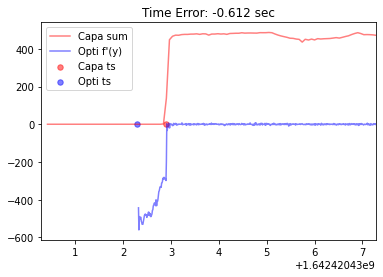

ID 1, size 4: (32005, 9)


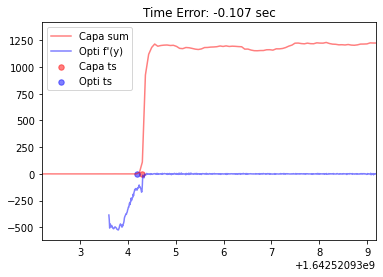

ID 1, size 8: (31873, 9)


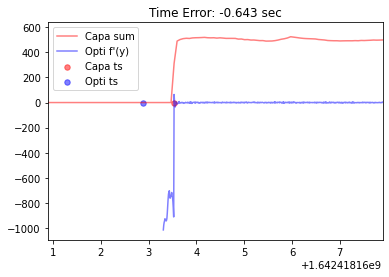

ID 2, size 4: (31460, 9)


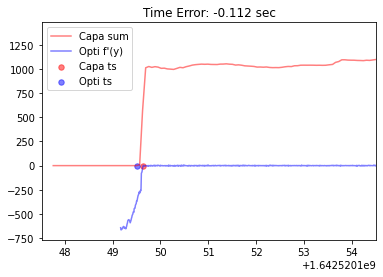

ID 2, size 8: (32050, 9)


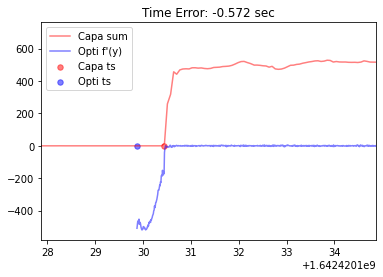

ID 47, size 4: (31736, 9)


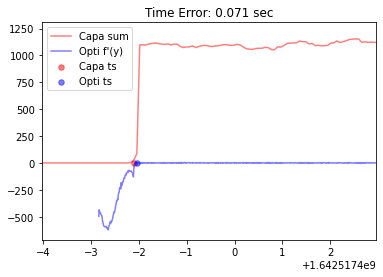

ID 47, size 8: (31819, 9)


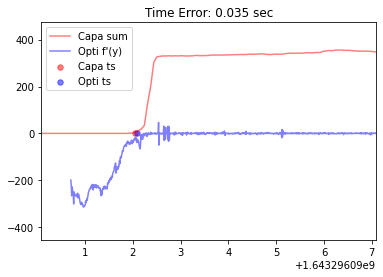

ID 0t, size 4: (32023, 9)


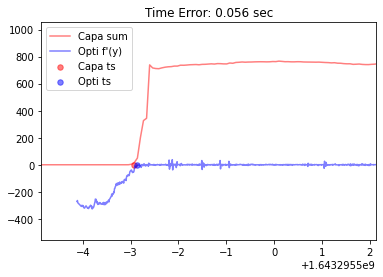

ID 0t, size 8: (31451, 9)


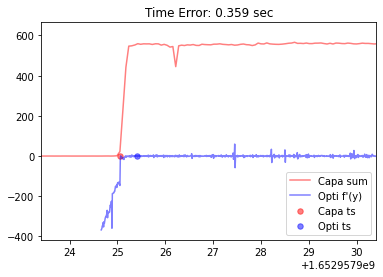

ID 1a, size 4: (30752, 9)


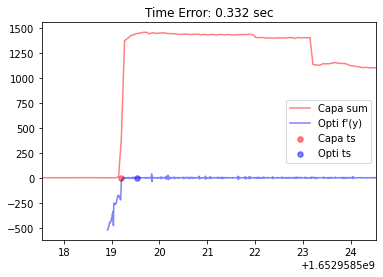

ID 1a, size 8: (31253, 9)


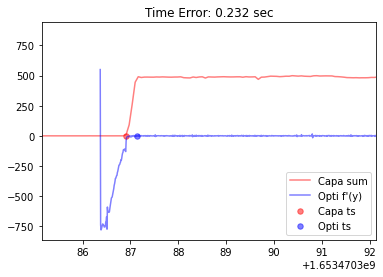

ID 6k, size 4: (29748, 9)


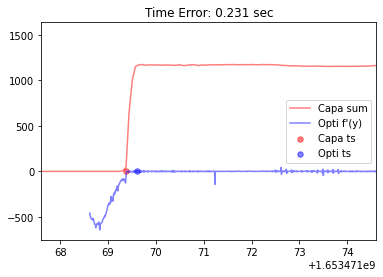

ID 6k, size 8: (30672, 9)


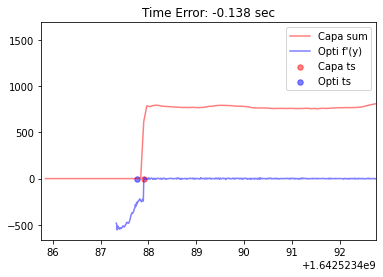

ID 1, size 6: (31442, 9)


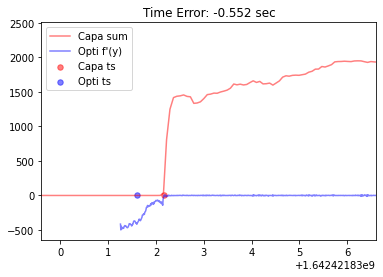

ID 1, size 12: (31543, 9)


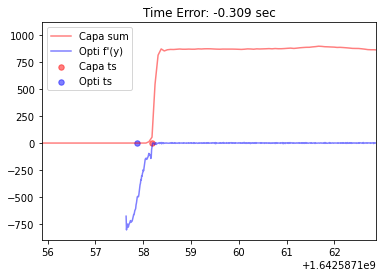

ID 2, size 6: (31305, 9)


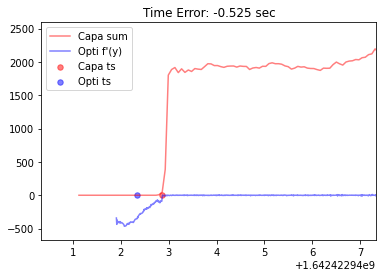

ID 2, size 12: (32262, 9)


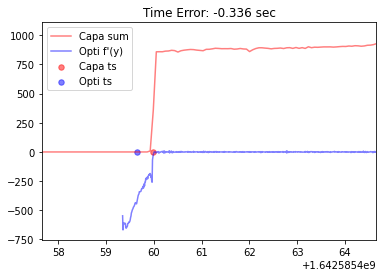

ID 47, size 6: (31842, 9)


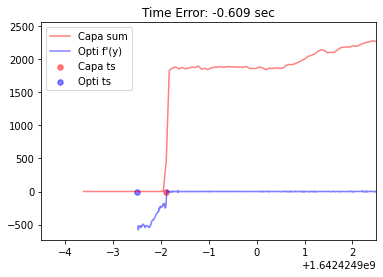

ID 47, size 12: (31737, 9)


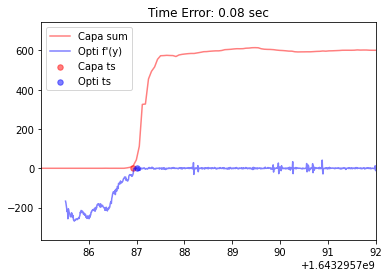

ID 0t, size 6: (31998, 9)


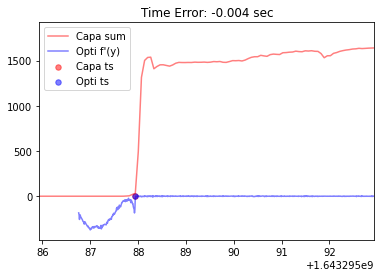

ID 0t, size 12: (31729, 9)


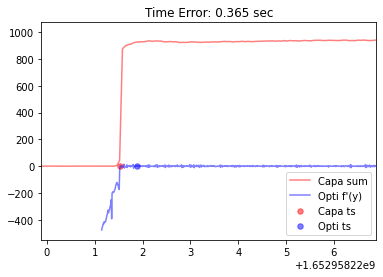

ID 1a, size 6: (31237, 9)


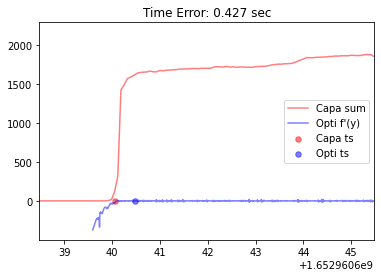

ID 1a, size 12: (30793, 9)


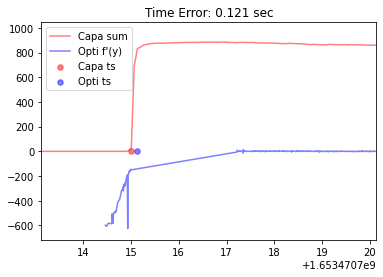

ID 6k, size 6: (30085, 9)


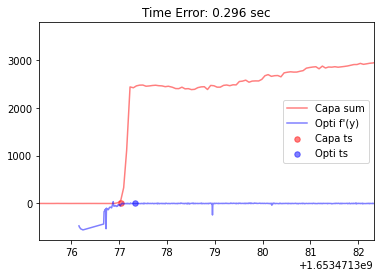

ID 6k, size 12: (30956, 9)
Dataset: (2, 6, 2), mean: 31407 (SD: 621)


In [76]:
opti_data = []
mean_opti = []
mean_time_error = []

for g, group in enumerate(perm_ids):
    group_data = []
    for i, ids in enumerate(group):
        id_data = []
        for j, (id, size) in enumerate(ids):
            df_opti, time_error = read_opti_file(f"./Data/OptiTrack/id{id}_{size}mm.csv", 0, capa_data[g,i,j], plot_sync=True)
            print(f"ID {id}, size {size}: {df_opti.shape}")
            mean_opti.append(df_opti.shape[0])
            mean_time_error.append(np.abs(time_error))
            id_data.append(df_opti)
        group_data.append(id_data)
    opti_data.append(group_data)
opti_data = np.asarray(opti_data, dtype=object)

print(f"Dataset: {opti_data.shape}, mean: {int(np.mean(mean_opti))} (SD: {int(np.std(mean_opti))})")

Now, we filter out potentially empty matrices and drop such rows in each DataFrame in `capa_data`.

In [77]:
# filter out weak matrices
filter_threshold = 0.4
new_shapes = []

for g, group in enumerate(perm_ids):
    for i, ids in enumerate(group):
        for j, (id, size) in enumerate(ids):
            sums = capa_data[g,i,j].Matrix.apply(lambda x: np.sum(x))
            capa_mean = np.mean(sums)
            weak_mats = list(i for i,x in enumerate(sums) if x <= capa_mean*filter_threshold)
            old_shape = capa_data[g,i,j].shape
            capa_data[g,i,j] = capa_data[g,i,j].drop(weak_mats).reset_index(drop=True)
            capa_data[g,i,j] = capa_data[g,i,j]
            new_shapes.append(capa_data[g,i,j].shape[0])
            print(f"ID {id}, size {size}: {old_shape} -> {capa_data[g,i,j].shape}")

print(f"Min shape: {np.min(new_shapes)}, mean shape: {int(np.mean(new_shapes))} (SD: {int(np.std(new_shapes))})")

ID 1, size 4: (4263, 2) -> (3947, 2)
ID 1, size 8: (4149, 2) -> (3925, 2)
ID 2, size 4: (4215, 2) -> (3887, 2)
ID 2, size 8: (4184, 2) -> (3930, 2)
ID 47, size 4: (4240, 2) -> (3840, 2)
ID 47, size 8: (4164, 2) -> (3882, 2)
ID 0t, size 4: (4229, 2) -> (3846, 2)
ID 0t, size 8: (4326, 2) -> (3815, 2)
ID 1a, size 4: (4350, 2) -> (3945, 2)
ID 1a, size 8: (4064, 2) -> (3815, 2)
ID 6k, size 4: (4002, 2) -> (3581, 2)
ID 6k, size 8: (3986, 2) -> (3706, 2)
ID 1, size 6: (4164, 2) -> (3904, 2)
ID 1, size 12: (3989, 2) -> (3668, 2)
ID 2, size 6: (4209, 2) -> (3892, 2)
ID 2, size 12: (4041, 2) -> (3792, 2)
ID 47, size 6: (4227, 2) -> (3901, 2)
ID 47, size 12: (3977, 2) -> (3717, 2)
ID 0t, size 6: (4255, 2) -> (3897, 2)
ID 0t, size 12: (4178, 2) -> (3780, 2)
ID 1a, size 6: (4277, 2) -> (3946, 2)
ID 1a, size 12: (3970, 2) -> (3698, 2)
ID 6k, size 6: (4107, 2) -> (3747, 2)
ID 6k, size 12: (3933, 2) -> (3595, 2)
Min shape: 3581, mean shape: 3819 (SD: 108)


## Merg data by source

Once we have our two lists `capa_data` and `opti_data`, we can create a new list `data_merg`. The DataFrames within this new list contain both the capacitive images and the OptiTrack data. Note that we assign the closest OptiTrack frame to each capacitive frame.

In [78]:
data_merg = []

for g, group in enumerate(perm_ids):
    group_data = []
    for i, ids in enumerate(group):
        id_data = []
        for j, (id, size) in enumerate(ids):
            df_merg = pd.merge_asof(capa_data[g,i,j], opti_data[g,i,j], on="TimeStampUnix", direction='nearest', tolerance=0.01)
            df_merg = df_merg.dropna()
            df_merg = df_merg.reset_index(drop=True)
            id_data.append(df_merg)
            print(f"ID {id}, size {size}: {df_merg.shape}")
        group_data.append(id_data)
    data_merg.append(group_data)
    
data_merg = np.asarray(data_merg, dtype=object)
print(f"Dataset: {data_merg.shape}")

ID 1, size 4: (3947, 10)
ID 1, size 8: (3925, 10)
ID 2, size 4: (3887, 10)
ID 2, size 8: (3930, 10)
ID 47, size 4: (3840, 10)
ID 47, size 8: (3882, 10)
ID 0t, size 4: (3846, 10)
ID 0t, size 8: (3815, 10)
ID 1a, size 4: (3945, 10)
ID 1a, size 8: (3815, 10)
ID 6k, size 4: (3575, 10)
ID 6k, size 8: (3706, 10)
ID 1, size 6: (3904, 10)
ID 1, size 12: (3668, 10)
ID 2, size 6: (3892, 10)
ID 2, size 12: (3792, 10)
ID 47, size 6: (3901, 10)
ID 47, size 12: (3717, 10)
ID 0t, size 6: (3897, 10)
ID 0t, size 12: (3780, 10)
ID 1a, size 6: (3946, 10)
ID 1a, size 12: (3698, 10)
ID 6k, size 6: (3712, 10)
ID 6k, size 12: (3589, 10)
Dataset: (2, 6, 2)


## Extract blobs 

We now apply blob detection to extract the fiducial markers.

It is beneficial to check whether the OptiTrack data is properly syncronized with the capacitive data. We can do this by comparing the bounding box with the angle. Here, the angles 45°, 135°, 225° and 315° should have the largest bounding box. For this, set `plot_box = True`.



ID 1, size 4: (3947, 10) -> (3947, 15)
ID 1, size 8: (3925, 10) -> (3925, 15)


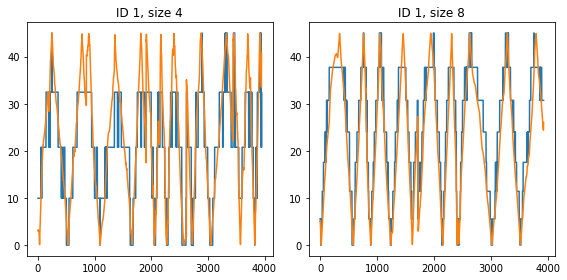

ID 2, size 4: (3887, 10) -> (3887, 15)
ID 2, size 8: (3930, 10) -> (3930, 15)


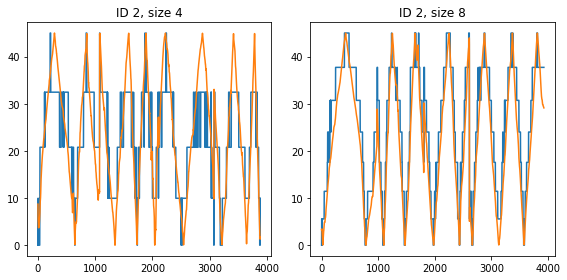

ID 47, size 4: (3840, 10) -> (3840, 15)
ID 47, size 8: (3882, 10) -> (3882, 15)


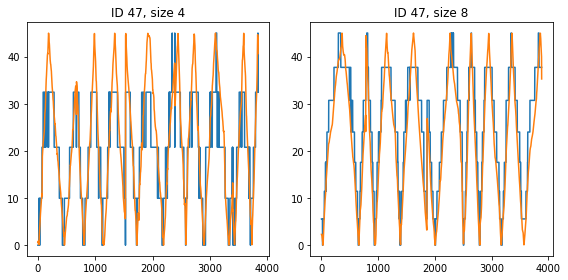

ID 0t, size 4: (3846, 10) -> (3846, 15)
ID 0t, size 8: (3815, 10) -> (3815, 15)


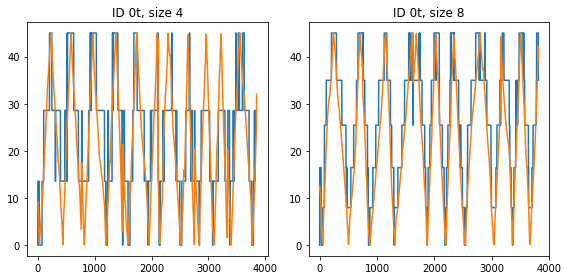

ID 1a, size 4: (3945, 10) -> (3945, 15)
ID 1a, size 8: (3815, 10) -> (3815, 15)


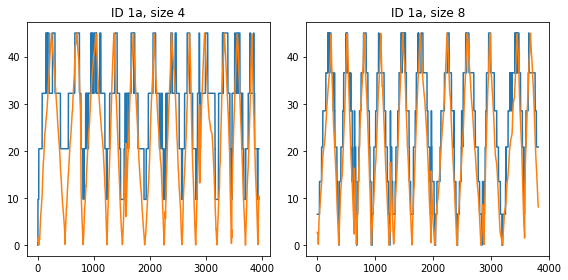

ID 6k, size 4: (3575, 10) -> (3575, 15)
ID 6k, size 8: (3706, 10) -> (3706, 15)


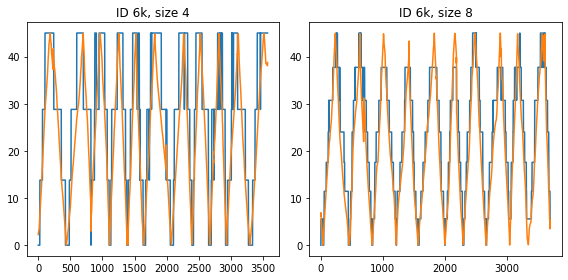

ID 1, size 6: (3904, 10) -> (3904, 15)
ID 1, size 12: (3668, 10) -> (3668, 15)


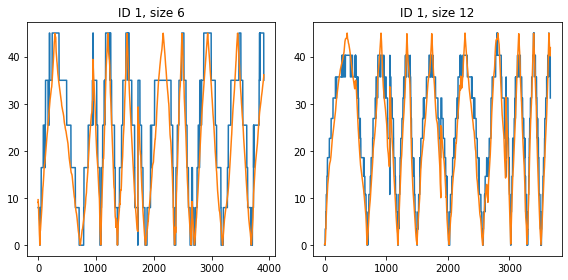

ID 2, size 6: (3892, 10) -> (3892, 15)
ID 2, size 12: (3792, 10) -> (3792, 15)


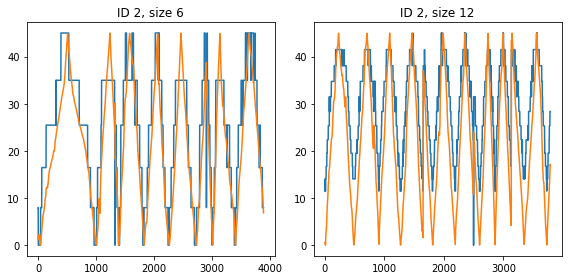

ID 47, size 6: (3901, 10) -> (3901, 15)
ID 47, size 12: (3717, 10) -> (3717, 15)


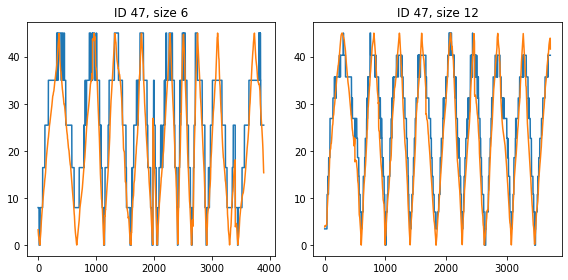

ID 0t, size 6: (3897, 10) -> (3897, 15)
ID 0t, size 12: (3780, 10) -> (3780, 15)


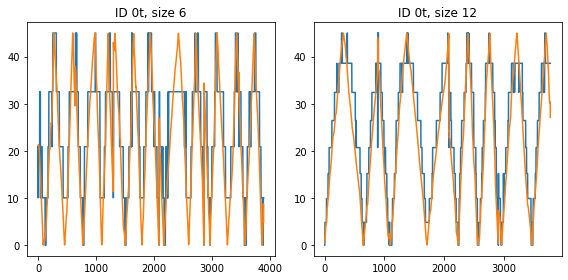

ID 1a, size 6: (3946, 10) -> (3946, 15)
ID 1a, size 12: (3698, 10) -> (3698, 15)


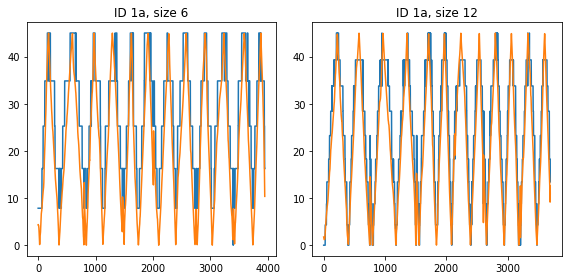

ID 6k, size 6: (3712, 10) -> (3712, 15)
ID 6k, size 12: (3589, 10) -> (3589, 15)


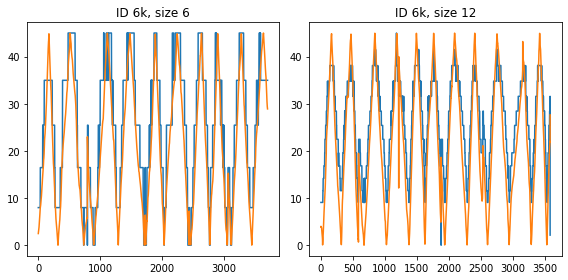

In [79]:
plot_box = True

for g, group in enumerate(perm_ids):
    for i, ids in enumerate(group):
        if plot_box:
            fig, ax = plt.subplots(1, data_merg.shape[2], figsize=(8, 4))
        for j, (id, size) in enumerate(ids):
            # we add blobs directly to the data, sice we need them later anyway
            old_shape = data_merg[g,i,j].shape
            data_merg[g,i,j] = add_blobs(data_merg[g,i,j], "Matrix", max_size = 100)
            print(f"ID {id}, size {size}: {old_shape} -> {data_merg[g,i,j].shape}")

            if plot_box:
                 # calculate bounding box and normalize to 0-45
                data_merg[g,i,j]["Bounding_Box"] = data_merg[g,i,j].Blob_H*data_merg[g,i,j].Blob_H
                data_merg[g,i,j]["Bounding_Box"] = 45*(data_merg[g,i,j]["Bounding_Box"] - np.min(data_merg[g,i,j]["Bounding_Box"]))/np.ptp(data_merg[g,i,j]["Bounding_Box"]) 
                ax[j].plot(np.arange(0, data_merg[g,i,j].shape[0]), data_merg[g,i,j].Bounding_Box)
                ax[j].plot(np.arange(0, data_merg[g,i,j].shape[0]), abs((abs((abs(data_merg[g,i,j].Angle-180)-90))-45))*-1 + 45)
                ax[j].set_title(f"ID {id}, size {size}")

        if plot_box:
            fig.tight_layout()
            plt.show()  

## Merge by angle

As we now have access to the angle of each capacitive image, we can merg the patches with the same ID into one large DataFrame. We save the resulting DataFrames in `data_angle_merg`.

In [80]:
merge_asof = False
data_angle_merg = []
mean_merg = []

for g, group in enumerate(perm_ids):
    group_data = []
    for i, ids in enumerate(group):
        data_merg_per_id = []
        temp_ids = []
        temp_sizes = []
        for j, (id, size) in enumerate(ids):
            # we copy the data for this to preserve the native names
            df_merg = data_merg[g,i,j].copy()
            old_shape = df_merg.shape
            df_merg = df_merg[["Angle", "Blob", "Blob_W", "Blob_H"]]
            # rename to keep track in merged frame
            if j == 0:
                df_merg = df_merg.rename(columns={"Blob": f"Blob_small"})
                df_merg = df_merg.rename(columns={"Blob_W": f"Blob_W_small"})
                df_merg = df_merg.rename(columns={"Blob_H": f"Blob_H_small"})
            elif j == 1:
                df_merg = df_merg.rename(columns={"Blob": f"Blob_large"})
                df_merg = df_merg.rename(columns={"Blob_W": f"Blob_W_large"})
                df_merg = df_merg.rename(columns={"Blob_H": f"Blob_H_large"})
            # sort for reduce
            df_merg = df_merg.sort_values("Angle")
            if not merge_asof:
                df_merg.Angle = df_merg.Angle.astype(int)
            data_merg_per_id.append(df_merg)
            temp_ids.append(id)
            temp_sizes.append(size)

        if not merge_asof:
            df_angle = reduce(lambda left,right: pd.merge(left, right, on="Angle", how="inner"), data_merg_per_id)
        else:
            df_angle = reduce(lambda left,right: pd.merge_asof(left, right, on="Angle", direction='nearest', tolerance=0.5), data_merg_per_id)
            df_angle.Angle = df_angle.Angle.astype(int)
        df_angle = df_angle.dropna()
        df_angle = df_angle.reset_index(drop=True)
        # add ID column
        df_angle["ID"] = f"id{temp_ids[0]}_{temp_sizes[0]}_{temp_sizes[1]}mm"
        print(f"IDs {temp_ids}, sizes {temp_sizes}: {old_shape} -> {df_angle.shape}")
        mean_merg.append(df_angle.shape[0])
        group_data.append(df_angle)
    data_angle_merg.append(group_data)

data_angle_merg = np.asarray(data_angle_merg, dtype=object)
print(f"Dataset: {data_angle_merg.shape}, mean shape: {int(np.mean(mean_merg))} (SD: {int(np.std(mean_merg))})")

IDs ['1', '1'], sizes ['4', '8']: (3925, 16) -> (42619, 8)
IDs ['2', '2'], sizes ['4', '8']: (3930, 16) -> (40652, 8)
IDs ['47', '47'], sizes ['4', '8']: (3882, 16) -> (44132, 8)
IDs ['0t', '0t'], sizes ['4', '8']: (3815, 16) -> (40524, 8)
IDs ['1a', '1a'], sizes ['4', '8']: (3815, 16) -> (42479, 8)
IDs ['6k', '6k'], sizes ['4', '8']: (3706, 16) -> (37732, 8)
IDs ['1', '1'], sizes ['6', '12']: (3668, 16) -> (42752, 8)
IDs ['2', '2'], sizes ['6', '12']: (3792, 16) -> (43204, 8)
IDs ['47', '47'], sizes ['6', '12']: (3717, 16) -> (44186, 8)
IDs ['0t', '0t'], sizes ['6', '12']: (3780, 16) -> (39963, 8)
IDs ['1a', '1a'], sizes ['6', '12']: (3698, 16) -> (40301, 8)
IDs ['6k', '6k'], sizes ['6', '12']: (3589, 16) -> (38437, 8)
Dataset: (2, 6), mean shape: 41415 (SD: 2036)


## Pad blobs

Now we want to pad the blobs within a unformly sized matrix.

In [81]:
for g, group in enumerate(perm_ids):
    for i, ids in enumerate(group):
        old_shape = data_angle_merg[g, i].shape
        data_angle_merg[g, i] = pad_and_center(data_angle_merg[g, i], [SMALL_SHAPE, LARGE_SHAPE])
        print(f"ID {data_angle_merg[g, i].ID.iloc[0]}: {old_shape} -> {data_angle_merg[g, i].shape}")

100%|██████████| 42619/42619 [00:02<00:00, 17698.73it/s]


ID id1_4_8mm: (42619, 8) -> (42619, 10)


100%|██████████| 40652/40652 [00:02<00:00, 17770.96it/s]


ID id2_4_8mm: (40652, 8) -> (40652, 10)


100%|██████████| 44132/44132 [00:02<00:00, 18072.45it/s]


ID id47_4_8mm: (44132, 8) -> (44132, 10)


100%|██████████| 40524/40524 [00:02<00:00, 18249.63it/s]


ID id0t_4_8mm: (40524, 8) -> (40524, 10)


100%|██████████| 42479/42479 [00:02<00:00, 18344.02it/s]


ID id1a_4_8mm: (42479, 8) -> (42479, 10)


100%|██████████| 37732/37732 [00:02<00:00, 18049.71it/s]


ID id6k_4_8mm: (37732, 8) -> (37732, 10)


100%|██████████| 42752/42752 [00:02<00:00, 17852.33it/s]


ID id1_6_12mm: (42752, 8) -> (42752, 10)


100%|██████████| 43204/43204 [00:02<00:00, 18294.16it/s]


ID id2_6_12mm: (43204, 8) -> (43204, 10)


100%|██████████| 44186/44186 [00:02<00:00, 17866.53it/s]


ID id47_6_12mm: (44186, 8) -> (44186, 10)


100%|██████████| 39963/39963 [00:02<00:00, 17766.74it/s]


ID id0t_6_12mm: (39963, 8) -> (39963, 10)


100%|██████████| 40301/40301 [00:02<00:00, 17177.41it/s]


ID id1a_6_12mm: (40301, 8) -> (40301, 10)


100%|██████████| 38437/38437 [00:02<00:00, 17982.93it/s]


ID id6k_6_12mm: (38437, 8) -> (38437, 10)


We can now see how the padded fiducial markers look like.

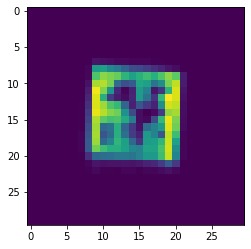

In [144]:
plt.imshow(data_angle_merg[1,0].Fill_Blob_small.iloc[1000], vmin = 0, vmax = 255)

## Add rotations

We now rotate each capacitive image 90°, 180° and 270° effectively increasing the size of the data by factor four. We also rename all columns to create a uniform naming.

In [82]:
data_rot_angle_merg = []
mean_rot = []

for g, group in enumerate(perm_ids):
    group_data = []
    for i, ids in enumerate(group):
        old_shape = data_angle_merg[g, i].shape
        data_angle_merg[g, i] = data_angle_merg[g, i][["Angle", "Fill_Blob_small", "Fill_Blob_large", "ID"]]
        concat_data = pd.DataFrame(columns= data_angle_merg[g, i].columns)
    
        for angle in [0, 90, 180, 270]:
            temp_dict = {"Angle": data_angle_merg[g, i].Angle.apply(lambda x: (x + angle) % 360), 
                                    "Fill_Blob_small": data_angle_merg[g, i].Fill_Blob_small.apply(lambda x: rotate_image(x, angle)),
                                    "Fill_Blob_large": data_angle_merg[g, i].Fill_Blob_large.apply(lambda x: rotate_image(x, angle)),
                                    "ID": data_angle_merg[g, i].ID}

            concat_data = pd.concat([concat_data, pd.DataFrame.from_dict(temp_dict)])

        print(f"ID {concat_data.ID.iloc[0]}: {old_shape} -> {concat_data.shape}")
        mean_rot.append(concat_data.shape[0])
        group_data.append(concat_data)
    data_rot_angle_merg.append(group_data)

data_rot_angle_merg = np.asarray(data_rot_angle_merg, dtype=object)
print(f"Dataset: {data_rot_angle_merg.shape}, mean shape: {int(np.mean(mean_rot))} (SD: {int(np.std(mean_rot))})")

ID id1_4_8mm: (42619, 10) -> (170476, 4)
ID id2_4_8mm: (40652, 10) -> (162608, 4)
ID id47_4_8mm: (44132, 10) -> (176528, 4)
ID id0t_4_8mm: (40524, 10) -> (162096, 4)
ID id1a_4_8mm: (42479, 10) -> (169916, 4)
ID id6k_4_8mm: (37732, 10) -> (150928, 4)
ID id1_6_12mm: (42752, 10) -> (171008, 4)
ID id2_6_12mm: (43204, 10) -> (172816, 4)
ID id47_6_12mm: (44186, 10) -> (176744, 4)
ID id0t_6_12mm: (39963, 10) -> (159852, 4)
ID id1a_6_12mm: (40301, 10) -> (161204, 4)
ID id6k_6_12mm: (38437, 10) -> (153748, 4)
Dataset: (2, 6), mean shape: 165660 (SD: 8147)


## Balance IDs

Here, want to make sure that all IDs are equally distributed relative to the angle. We use the median number of samples per angle (452) for this.

In [83]:
# use median
sample_num = 452
data_sampled = []

for g, group in enumerate(perm_ids):
    for i, ids in enumerate(group):
        data_sampled.append(data_rot_angle_merg[g, i].groupby("Angle").sample(sample_num, replace=True))

print(f"Dataset: {len(data_sampled)*data_sampled[0].shape[0]}, data per ID and size: {data_sampled[0].shape}")

Dataset: 1952640, data per ID and size: (162720, 4)


## Save data to csv

Now that everything is done, we can save the processed data to csv-files.
For this, we flatten the images and replace commas with spaces to preserve the csv format.
Note that we might need to create a folder manually.

In [ ]:
concat_ids = perm_ids[0] + perm_ids[1]

for i, df in enumerate(data_sampled):
    df_copy = df.copy()

    df_copy.Fill_Blob_small = df_copy.Fill_Blob_small.parallel_apply(lambda x: str(x.flatten().tolist()).replace(",", "").replace("]", "").replace("[", ""))
    df_copy.Fill_Blob_large = df_copy.Fill_Blob_large.parallel_apply(lambda x: str(x.flatten().tolist()).replace(",", "").replace("]", "").replace("[", ""))

    df_copy.to_csv(f"./Data/Processed/id{concat_ids[i][0][0]}_{concat_ids[i][0][1]}_{concat_ids[i][1][1]}.csv")

## Generative Adversarial Network

### Prepare data

First, we need to create training, validation and test datasets for the network.

In [84]:
# shape of the data for the GAN in and output
GAN_IN_SHAPE = (30,30,1)
GAN_OUT_SHAPE = (60,60,1)

data_stacked = pd.concat(data_sampled, ignore_index=True)
print(f"Dataset: {data_stacked.shape}")

Dataset: (1952640, 4)


### Load data from files

Alternatively, we can load the data from pickled files.

In [ ]:
data = []
files = ["train_data_pickled.obj", "val_data_pickled.obj", "test_data_pickled.obj"]
for f in files:
    file = open(f"./Data/Processed/{f}",'rb')
    data.append(pickle.load(file))
    file.close()

data_stacked = pd.concat(data, ignore_index=True)
print(f"Dataset: {data_stacked.shape}")

### Create datasets

We split the data and create DataGenerators for the networks.

In [85]:
class DataGenerator:
    
    def __init__(self, df, small_res, large_res, shift_std = 1, batch_size = 64, shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.df = df
        self.n_batches = int(np.round(len(self.df)/batch_size))
        self.small_res = small_res
        self.large_res = large_res
        self.shift_std = shift_std

    def __call__(self, shuffle=True):
        
        indexes = self.df.index.values
        if self.shuffle:
            np.random.shuffle(indexes)

        for i in range(self.n_batches-1):
            batch = indexes[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for i, e in self.df.loc[batch].iterrows():
                # get the blobs, reshape and add them to batch
                img_A = e.Fill_Blob_small
                img_B = e.Fill_Blob_large
                
                # shift with normal dist around 0
                for shift_axis in [0, 1]:
                    shift = int(np.random.normal(0, self.shift_std, 1))
                    img_A = np.roll(img_A, shift, axis = shift_axis)
                    img_B = np.roll(img_B, shift*int(self.large_res[0]/self.small_res[0]), axis = shift_axis)
                
                img_A = img_A.reshape([self.small_res[0],self.small_res[1],self.small_res[2]])
                img_B = img_B.reshape([self.large_res[0],self.large_res[1],self.large_res[2]])
                imgs_A.append(img_A)
                imgs_B.append(img_B)

            # normalize values to [-1,1]
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            # save as tensor 
            imgs_A = tf.convert_to_tensor(imgs_A)
            imgs_B = tf.convert_to_tensor(imgs_B)

            yield imgs_A, imgs_B

In [86]:
batch_size = 32

# sizes
sizes = ["_4_8mm", "_6_12mm"]

# training data
train_tags_id = ["id1_", "id2_", "id4_", "id7_", "id15_", "id29_", "id30_", "id33_"]

# validation data
val_tags_id = ["id47_", "id54_"]

# test data
test_tags_id = ["0t_", "2t_", "3t_"]

# separate tags and shapes for train
train_tags = pd.DataFrame(columns=data_stacked.columns)
for x in train_tags_id:
    train_tags = pd.concat([train_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)

# separate tags and shapes for val
val_tags = pd.DataFrame(columns=data_stacked.columns)
for x in val_tags_id:
    val_tags = pd.concat([val_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)
    
# separate tags and shapes for test
test_tags = pd.DataFrame(columns=data_stacked.columns)
for x in test_tags_id:
    test_tags = pd.concat([test_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)
    
# for testing, x IDs
gen_train_tags = DataGenerator(train_tags, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
gen_val_tags = DataGenerator(val_tags, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
gen_test_tags = DataGenerator(test_tags, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)

print(f"Training set tags: {gen_train_tags.df.shape}; {gen_train_tags.n_batches} batches with size {gen_train_tags.batch_size}")
print(f"Validation set tags: {gen_val_tags.df.shape}; {gen_val_tags.n_batches} batches with size {gen_val_tags.batch_size}")
print(f"Test set tags: {gen_test_tags.df.shape}; {gen_test_tags.n_batches} batches with size {gen_test_tags.batch_size}")

train_dataset_tags = tf.data.Dataset.from_generator(gen_train_tags, 
                                               output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                 )).prefetch(tf.data.AUTOTUNE)

val_dataset_tags = tf.data.Dataset.from_generator(gen_val_tags, 
                                              output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                )).prefetch(tf.data.AUTOTUNE)

test_dataset_tags = tf.data.Dataset.from_generator(gen_test_tags, 
                                                      output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                )).prefetch(tf.data.AUTOTUNE)

Training set tags: (650880, 4); 20340 batches with size 32
Validation set tags: (325440, 4); 10170 batches with size 32
Test set tags: (325440, 4); 10170 batches with size 32


### Load networks from file

We can load the networks featured in the paper directly and skip to the evaluation.

In [123]:
# load model from h5 file
model_name = "paper_GAN"
generator = models.load_model(f"./Models/{model_name}_gen.h5")
discriminator = models.load_model(f"./Models/{model_name}_disc.h5")

### Create the generator

In [112]:
def Generator(input_shape, target_shape):
    
    def residual2d(layer_input, filters):
        """ Layers used for feature extraction """
        # padding 'same' and strides 1 to preserve shape; no activation because of PReLU
        # block 1: conv - norm -prelu
        r1 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
        r1 = layers.BatchNormalization()(r1) 
        r1 = layers.PReLU()(r1)
        # block 2: conv - norm
        r2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(r1)
        r2 = layers.BatchNormalization()(r2) 
        # add block 1 and 2
        r3 = layers.Add()([layer_input, r2])
        return r3
        
    # Image input
    in_layer = tf.keras.layers.Input(shape=input_shape)
  
    # Preparation
    p = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(in_layer)
    p = layers.PReLU()(p)    
    
    # Residual blocks
    r = residual2d(p, 64)
    r = residual2d(r, 64)
    
    r = residual2d(r, 64)
    r = residual2d(r, 64)
    
    # Middle
    m = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(r) 
    m = layers.BatchNormalization()(m)
    m = layers.Add()([p, m])
    
    # Pixel shuffler (https://keras.io/examples/vision/super_resolution_sub_pixel/)
    ps = layers.Conv2D(64 * (2 ** 2), kernel_size=3, strides=1, padding='same')(m)
    ps = tf.nn.depth_to_space(ps, 2)
    ps = layers.PReLU()(ps)   

    # tanh to keep the output between -1 and 1, according to the input range
    out_layer = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', activation='tanh')(ps)
    
    model = models.Model(in_layer, out_layer, name = 'Generator')
    return model

In [113]:
generator = Generator(input_shape= GAN_IN_SHAPE, target_shape= GAN_OUT_SHAPE)
print(generator.summary())
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 30, 30, 64)   640         ['input_3[0][0]']                
                                                                                                  
 p_re_lu_12 (PReLU)             (None, 30, 30, 64)   57600       ['conv2d_44[0][0]']              
                                                                                                  
 conv2d_45 (Conv2D)             (None, 30, 30, 64)   36928       ['p_re_lu_12[0][0]']             
                                                                                          

### Create the discriminator

In [89]:
def Discriminator(input_shape, target_shape):
    
    def convolute2d(layer_input, filters):
        """Layers used during downsampling"""
        d = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
        d = layers.LayerNormalization()(d)
        d = layers.LeakyReLU()(d)
        
        d = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(d)
        d = layers.LayerNormalization()(d)
        d = layers.LeakyReLU()(d)
        return d 

    # Input layers for both small and large image
    img_B = tf.keras.layers.Input(shape=target_shape, name="Input Large")
    
    p = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(img_B)
    p = layers.LeakyReLU()(p)
    
    # Convolute images together 
    d = convolute2d(p, 64) 
    d = convolute2d(d, 128) 
    d = convolute2d(d, 256) 

    # 4x4 matrix with depth 1
    validity = layers.Conv2D(1, kernel_size=4, strides=1, padding='same', activation="sigmoid")(d) 

    model = models.Model(img_B, validity , name = 'Discriminator')
    return model

In [90]:
discriminator = Discriminator(input_shape= GAN_IN_SHAPE, target_shape= GAN_OUT_SHAPE)
print(discriminator.summary())
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Large (InputLayer)    [(None, 60, 60, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 64)        640       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 60, 60, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 layer_normalization_6 (Laye  (None, 60, 60, 64)       128       
 rNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 60, 60, 64)        0         
                                                     

### Create loss functions and optimizers

In [98]:
# usually at 100
L1_FAC = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (L1_FAC * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

In [92]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    # fake loss is disc output compared to matrix of 0
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss, real_loss, generated_loss

In [93]:
train_acc_object = tf.keras.metrics.BinaryAccuracy()
val_acc_object = tf.keras.metrics.BinaryAccuracy()

def accuracy(acc_object, disc_generated_output, disc_real_output):
    # calculate accuracy for both fake and real output just like the loss
    acc_object.update_state(tf.zeros_like(disc_generated_output), disc_generated_output)
    acc_object.update_state(tf.ones_like(disc_real_output), disc_real_output)
    return acc_object.result()

In [94]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 4e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4, beta_1=0.5)

generator.compile(optimizer= generator_optimizer)
discriminator.compile(optimizer= discriminator_optimizer)

### Define the training loop

Our custom training loop comes with an extensive logging function.

In [107]:
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate fake image
        gen_output = generator(input_image, training=True)

        # discriminate real image, then fake image
        disc_real_output = discriminator(target_image, training=True)

        disc_generated_output = discriminator(gen_output, training=True)

        # calculate gen and disc loss
        total_gen_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target_image)
        total_disc_loss, real_loss, generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        # calculate gradients
        generator_gradients = gen_tape.gradient(total_gen_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(total_disc_loss,
                                                  discriminator.trainable_variables)
        # apply gradients
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))
        
    # calculate accuracy
    disc_acc = accuracy(train_acc_object, disc_generated_output, disc_real_output)
        
    # return results as dict
    return {"gen_total_loss": total_gen_loss, "gen_gan_loss": gan_loss, "gen_l1_loss": l1_loss, 
            "disc_loss": total_disc_loss, "disc_real_loss": real_loss, "disc_gen_loss": generated_loss, 
            "disc_acc": disc_acc} 

def val_step(input_image, target_image):  
    # generate fake image
    gen_output = generator(input_image, training=False)

   # discriminate real image, then fake image
    disc_real_output = discriminator(target_image, training=False)  
    disc_generated_output = discriminator(gen_output, training=False)
 
    # calculate gen and disc loss
    total_gen_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target_image)
    total_disc_loss, real_loss, generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    # calculate accuracy
    disc_acc = accuracy(val_acc_object, disc_generated_output, disc_real_output)
        
    # return results as dict
    return {"gen_total_loss": total_gen_loss, "gen_gan_loss": gan_loss, "gen_l1_loss": l1_loss,
            "disc_loss": total_disc_loss, "disc_real_loss": real_loss, "disc_gen_loss": generated_loss, 
            "disc_acc": disc_acc} 

In [108]:
def fit(train_ds, val_ds, gen_train, gen_val, n_epochs, n_train_batches, n_val_batches, log_file, train_name, save_interval):    
    # calculate meta infos
    start_time = datetime.datetime.now()
    batch_size = gen_train.batch_size
    train_ds_size = gen_train.n_batches * gen_train.batch_size
    val_ds_size = gen_val.n_batches * gen_val.batch_size
    start_time = datetime.datetime.now()
        
    def write_log(epoch, images, log_type):
         # test the generator with random val sample        
        batch_take = list(images.take(1))[0]
        # the small matrix is index 0, the large index 1
        matrix_small = batch_take[0][0].numpy()
        matrix_large = batch_take[1][0].numpy()
        gen_output = generator(matrix_small[tf.newaxis, ...], training=False)
        gen_output = str(gen_output[0].numpy().flatten().tolist()).replace(",", "").replace("]", "").replace("[", "")
        matrix_small = str(matrix_small.flatten().tolist()).replace(",", "").replace("]", "").replace("[", "")
        matrix_large = str(matrix_large.flatten().tolist()).replace(",", "").replace("]", "").replace("[", "")
        
        # calculate mean and create df row
        current_time = datetime.datetime.now()
        train_row = pd.DataFrame.from_dict({# current info
                                            "epoch": [epoch], 
                                            "log_type": [log_type],
                                            # stats gen
                                            "gen_total_loss": [np.mean(epoch_log.gen_total_loss)], 
                                            "gen_gan_loss": [np.mean(epoch_log.gen_gan_loss)], 
                                            "gen_l1_loss": [np.mean(epoch_log.gen_l1_loss)],
                                            # stats disc
                                            "disc_loss": [np.mean(epoch_log.disc_loss)],
                                            "disc_real_loss": [np.mean(epoch_log.disc_real_loss)],
                                            "disc_gen_loss": [np.mean(epoch_log.disc_gen_loss)],
                                            "disc_acc": [np.mean(epoch_log.disc_acc)],
                                            # image
                                            "gen_input": [matrix_small],
                                            "gen_output": [gen_output],
                                            "exp_output": [matrix_large],
                                            # meta info
                                            "n_train_batches": [n_train_batches],
                                            "n_val_batches": [n_val_batches],
                                            "train_ds_size": [train_ds_size],
                                            "val_ds_size": [val_ds_size],
                                            "batch_size": [batch_size],
                                            # time
                                            "start_time": [start_time.strftime("%d/%m/%Y-%H:%M:%S")],
                                            "current_time": [current_time.strftime("%d/%m/%Y-%H:%M:%S")],
                                            "passed_time": [(current_time - start_time).total_seconds()],   
                                            "train_name": train_name})

        # append row to existing file
        train_row.to_csv(log_file, mode='a', index= False, header = False)
        
    # create log file
    log = pd.DataFrame(columns=["epoch", "log_type",
                                "gen_total_loss", "gen_gan_loss", "gen_l1_loss",
                                "disc_loss", "disc_real_loss", "disc_gen_loss", "disc_acc", 
                                "gen_input", "gen_output", "exp_output", 
                                "n_train_batches", "n_val_batches", 
                                "train_ds_size", "val_ds_size", "batch_size", 
                                "start_time", "current_time", "passed_time", "train_name"])
    log.to_csv(log_file, mode='w', index=False)
    
    for epoch in range(epochs):
        
        # start epoch with fresh log and accuracy
        epoch_log = pd.DataFrame(columns=["gen_total_loss", "gen_gan_loss", "gen_l1_loss", 
                                          "disc_loss", "disc_acc"])
        train_acc_object.reset_state()
        val_acc_object.reset_state()
        
        # update display for training
        IPython.display.clear_output(wait=True)
        print(f"Epoch {epoch+1}/{epochs} (training)")
        print(f"Current lr gen: {generator.optimizer.lr.numpy()}")
        print(f"Current lr disc: {discriminator.optimizer.lr.numpy()}")
        out = display(progress(0, n_train_batches-1), display_id=True)
        
        # train: take from dataset and process batches
        train_batches = train_ds.take(n_train_batches)
        for n, (input_image, target_image) in train_batches.enumerate():
            
            # convert tensors to numpy and append log to to epoch_log
            train_log = train_step(input_image, target_image)
            train_log = {k: v.numpy() for k, v in train_log.items()}
            epoch_log = epoch_log.append(train_log, ignore_index=True)
             
            # update display
            out.update(progress(n, n_train_batches-1))
        
        # write train log after each epoch (apart from in-epoch logging); reset is done at the next start
        write_log(epoch, train_batches, "training")
        
        # update display for validation
        IPython.display.clear_output(wait=True)
        print(f"Epoch {epoch+1}/{epochs} (validation)")
        out = display(progress(0, n_val_batches-1), display_id=True)
            
        # val: take from dataset and process batches
        val_batches = val_ds.take(n_val_batches)
        for n, (input_image, target_image) in val_batches.enumerate():           
            # convert tensors to numpy and append log to to epoch_log
            val_log = val_step(input_image, target_image)
            val_log = {k: v.numpy() for k, v in val_log.items()}
            epoch_log = epoch_log.append(val_log, ignore_index=True)
            
            # update display
            out.update(progress(n, n_val_batches-1))
        
        # write val log after each epoch; reset is done at the next start
        write_log(epoch, val_batches, "validation")

### Train the network

In [109]:
epochs = 3
train_batches = 1 #360
val_batches = 1 #90
train_name = "8/2 ID Split"

# define place to save logs
log_dir="./Logs/"
log_file = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +".csv"

fit(train_dataset_tags, val_dataset_tags, gen_train_tags, gen_val_tags, epochs, train_batches, val_batches, log_file, train_name, 50)

Epoch 3/3 (validation)


/opt/jupyterhub/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/tmp/ipykernel_1476558/3594797157.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  epoch_log = epoch_log.append(val_log, ignore_index=True)


### Save network

In [ ]:
# save model to h5 file
model_name = "test_GAN"
generator.save(f"./Models/{model_name}_gen.h5")
discriminator.save(f"./Models/{model_name}_disc.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(generator)
tflite_model = converter.convert()

# Save the model.
with open(f"./Models/{model_name}_gen.tflite", 'wb') as f:
    f.write(tflite_model)

## Evaluate log

As mentioned, the custom training loop comes with a logging function. We can now evaluate the log.

In [115]:
def draw_dashboard(file):        
    df = pd.read_csv(file)
    df = df.dropna()
    df = df.reset_index(drop=True)

    if df.empty:
        print("Nothing here yet")
        return

    # split logs
    train_log = df.loc[df.log_type == "training"]
    val_log = df.loc[df.log_type == "validation"]

    fig, ax = plt.subplots(6, 3, figsize=(12, 24)) 

    # reshape latest images from train data
    gen_input_train = np.asarray(train_log.gen_input.iloc[-1].split(" ")).astype(np.float32).reshape(GAN_IN_SHAPE)
    gen_output_train = np.asarray(train_log.gen_output.iloc[-1].split(" ")).astype(np.float32).reshape(GAN_OUT_SHAPE)
    exp_output_train = np.asarray(train_log.exp_output.iloc[-1].split(" ")).astype(np.float32).reshape(GAN_OUT_SHAPE)
     # reshape latest images from val data
    gen_input_val = np.asarray(val_log.gen_input.iloc[-1].split(" ")).astype(np.float32).reshape(GAN_IN_SHAPE)
    gen_output_val = np.asarray(val_log.gen_output.iloc[-1].split(" ")).astype(np.float32).reshape(GAN_OUT_SHAPE)
    exp_output_val = np.asarray(val_log.exp_output.iloc[-1].split(" ")).astype(np.float32).reshape(GAN_OUT_SHAPE)

    # calculate x values
    x_vals_train = list(row.epoch + 1 for n, row in train_log.iterrows())
    x_vals_val = list(row.epoch + 1 for n, row in val_log.iterrows())
    x_epochs = train_log.epoch.max() + 1
    x_ticks = list(np.arange(1, x_epochs, max(1, int(x_epochs/5)))) + [x_epochs]

    # row 1: show disc stats
    ax[0][0].plot([],[])
    ax[0][0].set_title("")
    ax[0][0].text(-0.0575, -0.0475, 
f"""
Train name: {df.train_name.iloc[0]}

Start time: {df.start_time.iloc[0]}
Passed time: {int(df.passed_time.iloc[-1])}s
Current epoch: {df.epoch.iloc[-1] + 1}

Batch size: {df.batch_size.iloc[0]}
Train batches: {df.n_train_batches.iloc[0]}
Val batches: {df.n_val_batches.iloc[0]}

Train size: {df.train_ds_size.iloc[0]} 
Val size: {df.val_ds_size.iloc[0]} """
    , fontsize=11, bbox={'facecolor': 'gray', 'alpha': 0.2, 'pad': 10})

    # row 1 empty
    ax[0][0].axis('off')
    ax[0][1].axis('off')
    ax[0][2].axis('off')

    # row 2
    ax[1][0].plot(x_vals_train, list(train_log.disc_loss))
    ax[1][0].plot(x_vals_val, list(val_log.disc_loss))
    ax[1][0].set_title("Discriminator total loss")
    ax[1][0].set_xlabel(f"Last: {np.round(train_log.disc_loss.iloc[-1], 3)}")
    ax[1][0].set_xticks(x_ticks)
    ax[1][0].grid(axis = 'x')
    ax[1][0].grid(axis = 'y', alpha=0.3)

    # backwards compat
    """if "gen_threshold_loss" in train_log.columns:
        ax[1][1].plot(x_vals_train, list(train_log.gen_threshold_loss))
        ax[1][1].plot(x_vals_val, list(val_log.gen_threshold_loss))
        ax[1][1].set_title("Generator threshold loss")
        ax[1][1].set_xlabel(f"Last: {np.round(train_log.gen_threshold_loss.iloc[-1], 3)}")
        ax[1][1].set_xticks(x_ticks)
        ax[1][1].grid(axis = 'x')
        ax[1][1].grid(axis = 'y', alpha=0.3)
    else:"""
    ax[1][1].axis('off')
    ax[1][1].plot([0, 1], [0, 1], c= 'k')
    ax[1][1].plot([0, 1], [1, 0], c= 'k')

    # backwards compat
    if "disc_real_loss" in train_log.columns:
        ax[1][2].plot(x_vals_train, list(train_log.disc_real_loss))
        ax[1][2].plot(x_vals_val, list(val_log.disc_real_loss))
        ax[1][2].set_title("Discriminator real loss")
        ax[1][2].set_xlabel(f"Last: {np.round(train_log.disc_real_loss.iloc[-1], 3)}")
        ax[1][2].set_xticks(x_ticks)
        ax[1][2].grid(axis = 'x')
        ax[1][2].grid(axis = 'y', alpha=0.3)
    else:
        ax[1][2].axis('off')
        ax[1][2].plot([0, 1], [0, 1], c= 'k')
        ax[1][2].plot([0, 1], [1, 0], c= 'k')

    # row 3
    # backwards compat
    if "disc_gen_loss" in train_log.columns:
        ax[2][0].plot(x_vals_train, list(train_log.disc_gen_loss))
        ax[2][0].plot(x_vals_val, list(val_log.disc_gen_loss))
        ax[2][0].set_title("Discriminator gen loss")
        ax[2][0].set_xlabel(f"Last: {np.round(train_log.disc_gen_loss.iloc[-1], 3)}")
        ax[2][0].set_xticks(x_ticks)
        ax[2][0].grid(axis = 'x')
        ax[2][0].grid(axis = 'y', alpha=0.3)
    else:
        ax[2][0].axis('off')
        ax[2][0].plot([0, 1], [0, 1], c= 'k')
        ax[2][0].plot([0, 1], [1, 0], c= 'k')

    #
    ax[2][1].plot(x_vals_train, list(train_log.disc_acc))
    ax[2][1].plot(x_vals_val, list(val_log.disc_acc))
    ax[2][1].set_title("Discriminator accuracy")
    ax[2][1].set_xlabel(f"Last: {np.round(train_log.disc_acc.iloc[-1], 3)}")
    ax[2][1].set_xticks(x_ticks)
    ax[2][1].grid(axis = 'x')
    ax[2][1].grid(axis = 'y', alpha=0.3)

    #  
    ax[2][2].plot(x_vals_train, list(train_log.gen_total_loss))
    ax[2][2].plot(x_vals_val, list(val_log.gen_total_loss))
    ax[2][2].set_title("Generator total loss")
    ax[2][2].set_xlabel(f"Last: {np.round(train_log.gen_total_loss.iloc[-1], 3)}")
    ax[2][2].set_xticks(x_ticks)
    ax[2][2].grid(axis = 'x')
    ax[2][2].grid(axis = 'y', alpha=0.3)

    # row 4
    ax[3][0].plot(x_vals_train, list(train_log.gen_l1_loss))
    ax[3][0].plot(x_vals_val, list(val_log.gen_l1_loss))
    ax[3][0].set_title("Generator l1 loss")
    ax[3][0].set_xlabel(f"Last: {np.round(train_log.gen_l1_loss.iloc[-1], 3)}")
    ax[3][0].set_xticks(x_ticks)
    ax[3][0].grid(axis = 'x')
    ax[3][0].grid(axis = 'y', alpha=0.3)

    # backwards compat
    if "gen_mmse_loss" in train_log.columns:
        ax[3][1].plot(x_vals_train, list(train_log.gen_mmse_loss))
        ax[3][1].plot(x_vals_val, list(val_log.gen_mmse_loss))
        ax[3][1].set_title("Discriminator mmae/mmse loss")
        ax[3][1].set_xlabel(f"Last: {np.round(train_log.gen_mmse_loss.iloc[-1], 3)}")
        ax[3][1].set_xticks(x_ticks)
        ax[3][1].grid(axis = 'x')
        ax[3][1].grid(axis = 'y', alpha=0.3)
    else:
        ax[3][1].axis('off')
        ax[3][1].plot([0, 1], [0, 1], c= 'k')
        ax[3][1].plot([0, 1], [1, 0], c= 'k')

    #
    ax[3][2].plot(x_vals_train, list(train_log.gen_gan_loss))
    ax[3][2].plot(x_vals_val, list(val_log.gen_gan_loss))
    ax[3][2].set_title("Generator GAN loss")
    ax[3][2].set_xlabel(f"Last: {np.round(train_log.gen_gan_loss.iloc[-1], 3)}")
    ax[3][2].set_xticks(x_ticks)
    ax[3][2].grid(axis = 'x')
    ax[3][2].grid(axis = 'y', alpha=0.3)

    # row 5: show the images from train
    ax[4][0].imshow(gen_input_train, vmin = -1, vmax = 1)
    ax[4][0].set_title("Generator input train")
    ax[4][1].imshow(gen_output_train, vmin = -1, vmax = 1)
    ax[4][1].set_title("Generator output train")
    ax[4][2].imshow(exp_output_train, vmin = -1, vmax = 1)
    ax[4][2].set_title("Expected output train")

    # row 6: show the images from val
    ax[5][0].imshow(gen_input_val, vmin = -1, vmax = 1)
    ax[5][0].set_title("Generator input val")
    ax[5][1].imshow(gen_output_val, vmin = -1, vmax = 1)
    ax[5][1].set_title("Generator output val")
    ax[5][2].imshow(exp_output_val, vmin = -1, vmax = 1)
    ax[5][2].set_title("Expected output val")

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

    # clear and draw
    plt.show()

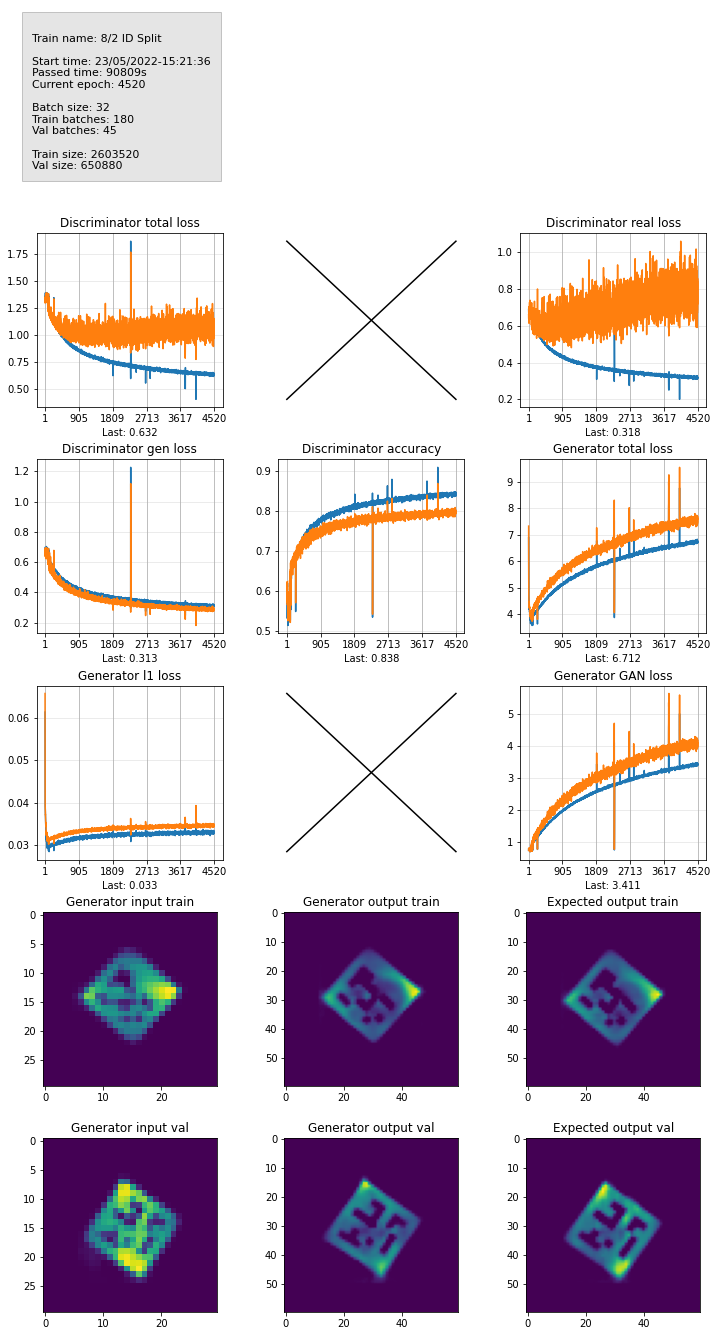

In [116]:
log_file = "./Logs/paper_log.csv"
draw_dashboard(log_file)

## Evaluate network

### Prepate evaluation

Here, we define fiducial detection algorithms. We also split the data by fiducial type and condition for fine grained assessment.

In [117]:
# Tag detector
detector_36h11 = dt_apriltags.Detector(searchpath=['apriltags'], families='tag36h11', quad_sigma=0.4, decode_sharpening=0.8)
detector_16h5 = dt_apriltags.Detector(searchpath=['apriltags'], families='tag16h5', quad_sigma=0.4, decode_sharpening=0.8)  

In [118]:
aruco_dict_36h11 = aruco.Dictionary_get(cv2.aruco.DICT_APRILTAG_36h11)
aruco_dict_16h5 = aruco.Dictionary_get(cv2.aruco.DICT_APRILTAG_16h5)
aruco_dict_original = aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)

parameters = aruco.DetectorParameters_create()
parameters.minMarkerPerimeterRate = 0.03
parameters.maxMarkerPerimeterRate = 4
parameters.polygonalApproxAccuracyRate = 0.1
parameters.minCornerDistanceRate = 0.05
parameters.minDistanceToBorder = 3
parameters.perspectiveRemovePixelPerCell = 14
parameters.perspectiveRemoveIgnoredMarginPerCell = 0.13
parameters.maxErroneousBitsInBorderRate = 0.35
parameters.errorCorrectionRate =0.6

In [119]:
class DataGeneratorDetectorEval:
    
    def __init__(self, df, small_res, large_res, shift_std = 1, batch_size = 64, shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.df = df
        self.n_batches = int(np.round(len(self.df)/batch_size))
        self.small_res = small_res
        self.large_res = large_res
        self.shift_std = shift_std

    def __call__(self, shuffle=True):
        
        indexes = self.df.index.values
        if self.shuffle:
            np.random.shuffle(indexes)

        for i in range(self.n_batches-1):
            batch = indexes[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B, angles, ids = [], [], [], []
            for i, e in self.df.loc[batch].iterrows():
                # get the blobs, reshape and add them to batch
                img_A = e.Fill_Blob_small
                img_B = e.Fill_Blob_large
                
                # shift with normal dist around 0
                for shift_axis in [0, 1]:
                    shift = int(np.random.normal(0, self.shift_std, 1))
                    img_A = np.roll(img_A, shift, axis = shift_axis)
                    img_B = np.roll(img_B, shift*int(self.large_res[0]/self.small_res[0]), axis = shift_axis)
                
                img_A = img_A.reshape([self.small_res[0],self.small_res[1],self.small_res[2]])
                img_B = img_B.reshape([self.large_res[0],self.large_res[1],self.large_res[2]])
                imgs_A.append(img_A)
                imgs_B.append(img_B)
                angles.append(e.Angle)
                ids.append(e.ID)

            # normalize values to [-1,1]
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            # save as tensor 
            imgs_A = tf.convert_to_tensor(imgs_A)
            imgs_B = tf.convert_to_tensor(imgs_B)
            angles = tf.convert_to_tensor(angles)
            ids = tf.convert_to_tensor(ids)

            yield imgs_A, imgs_B, angles, ids

In [120]:
# sizes
sizes = ["_4_8mm", "_6_12mm"]

# training data
train_tags_id = ["id1_", "id2_", "id4_", "id7_", "id15_", "id29_", "id30_", "id33_"]

# validation data
val_tags_id = ["id47_", "id54_"]

# test data
test_tags_id = ["0t_", "2t_", "3t_"]

# test data aruco
test_tags_aruco_id = ["1a_", "4a_", "10a_"]

# test data artk
test_tags_artk_id = ["6k_", "12k_", "15k_"]

# separate tags and shapes for train
train_tags = pd.DataFrame(columns=data_stacked.columns)
for x in train_tags_id:
    train_tags = pd.concat([train_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)

# separate tags and shapes for val
val_tags = pd.DataFrame(columns=data_stacked.columns)
for x in val_tags_id:
    val_tags = pd.concat([val_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)
    
# separate tags and shapes for test
test_tags = pd.DataFrame(columns=data_stacked.columns)
for x in test_tags_id:
    test_tags = pd.concat([test_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)
    
# separate tags and shapes for test
test_tags = pd.DataFrame(columns=data_stacked.columns)
for x in test_tags_id:
    test_tags = pd.concat([test_tags, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)
    
test_tags_aruco = pd.DataFrame(columns=data_stacked.columns)
for x in test_tags_aruco_id:
    test_tags_aruco = pd.concat([test_tags_aruco, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)

test_tags_artk = pd.DataFrame(columns=data_stacked.columns)
for x in test_tags_artk_id:
    test_tags_artk = pd.concat([test_tags_artk, data_stacked.loc[data_stacked.ID.str.contains(x)]], ignore_index=True)
    
# separate small and large sizes for train
train_tags_small = pd.DataFrame(columns=data_stacked.columns) 
train_tags_large = pd.DataFrame(columns=data_stacked.columns)
train_tags_small = pd.concat([train_tags_small, train_tags.loc[train_tags.ID.str.contains(sizes[0])]], ignore_index=True)
train_tags_large = pd.concat([train_tags_large, train_tags.loc[train_tags.ID.str.contains(sizes[1])]], ignore_index=True)

val_tags_small = pd.DataFrame(columns=data_stacked.columns) 
val_tags_large = pd.DataFrame(columns=data_stacked.columns)
val_tags_small = pd.concat([val_tags_small, val_tags.loc[val_tags.ID.str.contains(sizes[0])]], ignore_index=True)
val_tags_large = pd.concat([val_tags_large, val_tags.loc[val_tags.ID.str.contains(sizes[1])]], ignore_index=True)
    
test_tags_small = pd.DataFrame(columns=data_stacked.columns) 
test_tags_large = pd.DataFrame(columns=data_stacked.columns)
test_tags_small = pd.concat([test_tags_small, test_tags.loc[test_tags.ID.str.contains(sizes[0])]], ignore_index=True)
test_tags_large = pd.concat([test_tags_large, test_tags.loc[test_tags.ID.str.contains(sizes[1])]], ignore_index=True)

test_tags_aruco_small = pd.DataFrame(columns=data_stacked.columns) 
test_tags_aruco_large = pd.DataFrame(columns=data_stacked.columns)
test_tags_aruco_small = pd.concat([test_tags_aruco_small, test_tags_aruco.loc[test_tags_aruco.ID.str.contains(sizes[0])]], ignore_index=True)
test_tags_aruco_large = pd.concat([test_tags_aruco_large, test_tags_aruco.loc[test_tags_aruco.ID.str.contains(sizes[1])]], ignore_index=True)
    
test_tags_artk_small = pd.DataFrame(columns=data_stacked.columns) 
test_tags_artk_large = pd.DataFrame(columns=data_stacked.columns)
test_tags_artk_small = pd.concat([test_tags_artk_small, test_tags_artk.loc[test_tags_artk.ID.str.contains(sizes[0])]], ignore_index=True)
test_tags_artk_large = pd.concat([test_tags_artk_large, test_tags_artk.loc[test_tags_artk.ID.str.contains(sizes[1])]], ignore_index=True)
                                 
print(f"Training set tags: {train_tags.shape}")
print(f"Validation set tags: {val_tags.shape}")
print(f"Test set tags: {test_tags.shape}")
print(f"Test set tags aruco: {test_tags_aruco.shape}")
print(f"Test set tags artk: {test_tags_artk.shape}")

Training set tags: (650880, 4)
Validation set tags: (325440, 4)
Test set tags: (325440, 4)
Test set tags aruco: (325440, 4)
Test set tags artk: (325440, 4)


In [121]:
# choose a large batch size for evaluation
batch_size = 128

# for testing, x IDs
gen_train_tags = DataGenerator(train_tags, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
gen_val_tags = DataGenerator(val_tags, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
gen_test_tags = DataGenerator(test_tags, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
gen_test_tags_aruco = DataGenerator(test_tags_aruco, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
gen_test_tags_artk = DataGenerator(test_tags_artk, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)


train_dataset_tags = tf.data.Dataset.from_generator(gen_train_tags, 
                                               output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                 )).prefetch(tf.data.AUTOTUNE)

val_dataset_tags = tf.data.Dataset.from_generator(gen_val_tags, 
                                              output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                )).prefetch(tf.data.AUTOTUNE)


test_dataset_tags = tf.data.Dataset.from_generator(gen_test_tags, 
                                                      output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                )).prefetch(tf.data.AUTOTUNE)

test_dataset_tags_aruco = tf.data.Dataset.from_generator(gen_test_tags_aruco, 
                                                      output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                )).prefetch(tf.data.AUTOTUNE)

test_dataset_tags_artk = tf.data.Dataset.from_generator(gen_test_tags_artk, 
                                                      output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                )).prefetch(tf.data.AUTOTUNE)

### Image quality - Histogram

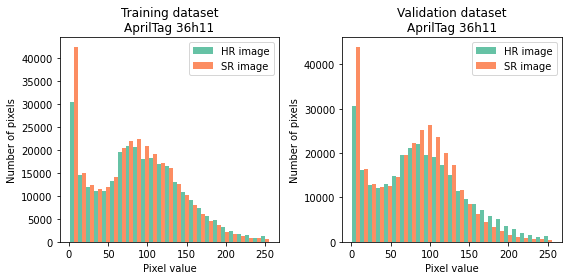

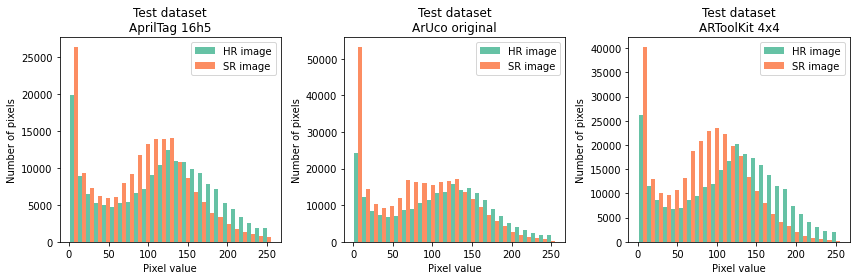

In [124]:
n_batches = 5

# if True, then n_batches is ignored
do_all = False

# fill with colors
colors = plt.get_cmap('Set2').colors 

def compute_pix_hist(dataset, n_batches, do_all = False):
    pix_t = []
    pix_p = []
    
    if not do_all:
        batches = dataset.take(n_batches)
    else:
        batches = dataset

    for n, (input_image, target_image) in batches.enumerate(): 
        gen_output = ((generator(input_image, training=False) + 1) * 127.5).numpy()
        target_image = ((target_image + 1) * 127.5).numpy()
        pix_t.append(target_image)
        pix_p.append(gen_output)
    return np.asarray(pix_t).flatten().astype(np.ubyte), np.asarray(pix_p).flatten().astype(np.ubyte)

train_t, train_p = compute_pix_hist(train_dataset_tags, n_batches, do_all = do_all)
val_t, val_p = compute_pix_hist(val_dataset_tags, n_batches, do_all = do_all)
test_t, test_p = compute_pix_hist(test_dataset_tags, n_batches, do_all = do_all)
test_t_aruco, test_p_aruco = compute_pix_hist(test_dataset_tags_aruco, n_batches, do_all = do_all)
test_t_artk, test_p_artk = compute_pix_hist(test_dataset_tags_artk, n_batches, do_all = do_all)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist([train_t[train_t > 0], train_p[train_p > 0]], label=["HR image", "SR image"], bins = 25, histtype='bar', rwidth=1, color = [colors[0], colors[1]])
ax[0].set_xlabel("Pixel value")
ax[0].set_title("Training dataset\nAprilTag 36h11")
ax[0].set_ylabel("Number of pixels")
ax[0].legend()

ax[1].hist([val_t[val_t > 0], val_p[val_p > 0]], label=["HR image", "SR image"], bins = 25, histtype='bar', rwidth=1, color = [colors[0], colors[1]])
ax[1].set_xlabel("Pixel value")
ax[1].set_title("Validation dataset\nAprilTag 36h11")
ax[1].set_ylabel("Number of pixels")
ax[1].legend()
        
fig.tight_layout()
fig.savefig('./Figs/pix_histograms_1.svg', format='svg', dpi=120, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].hist([test_t[test_t > 0], test_p[test_p > 0]], label=["HR image", "SR image"], bins = 25, histtype='bar', rwidth=1, color = [colors[0], colors[1]])
ax[0].set_xlabel("Pixel value")
ax[0].set_title("Test dataset\nAprilTag 16h5")
ax[0].set_ylabel("Number of pixels")
ax[0].legend()

ax[1].hist([test_t_aruco[test_t_aruco > 0], test_p_aruco[test_p_aruco > 0]], label=["HR image", "SR image"], bins = 25, histtype='bar', rwidth=1, color = [colors[0], colors[1]])
ax[1].set_xlabel("Pixel value")
ax[1].set_title("Test dataset\nArUco original")
ax[1].set_ylabel("Number of pixels")
ax[1].legend()

ax[2].hist([test_t_artk[test_t_artk > 0], test_p_artk[test_p_artk > 0]], label=["HR image", "SR image"], bins = 25, histtype='bar', rwidth=1, color = [colors[0], colors[1]])
ax[2].set_xlabel("Pixel value")
ax[2].set_title("Test dataset\nARToolKit 4x4")
ax[2].set_ylabel("Number of pixels")
ax[2].legend()
        
fig.tight_layout()
fig.savefig('./Figs/pix_histograms_2.svg', format='svg', dpi=120, bbox_inches="tight")
plt.show()

## Image quality - MAE, SSIM, PSNR

In [126]:
n_batches = 5

# if True, then n_batches is ignored
do_all = False

batch_size = 128
sizes = ["_4_8mm", "_6_12mm"]

mae_object = tf.keras.losses.MeanAbsoluteError()

def compute_extended_stats(dataset, n_batches, do_all= False):
    mean_mae = []
    mean_ssim = []
    mean_psnr = []
    
    mean_mae_bs_lanczos = []
    mean_ssim_bs_lanczos = []
    mean_psnr_bs_lanczos = []
    
    if not do_all:
        batches = dataset.take(n_batches)
    else:
        batches = dataset

    for n, (input_image, target_image) in batches.enumerate(): 
        gen_output = tf.cast(((generator(input_image, training=False) + 1) * 127.5), tf.int32)
        target_image = tf.cast(((target_image + 1) * 127.5), tf.int32)
        
        mean_mae.append(mae_object(target_image, gen_output).numpy())
        mean_ssim.append(tf.image.ssim(target_image, gen_output, max_val=255).numpy())
        mean_psnr.append(tf.image.psnr(target_image, gen_output, max_val=255).numpy())
        lanczos_image = tf.cast(((tf.image.resize(input_image, [60,60], method=tf.image.ResizeMethod.LANCZOS3) + 1) * 127.5), tf.int32)
        
        mean_mae_bs_lanczos.append(mae_object(target_image, lanczos_image).numpy())
        mean_ssim_bs_lanczos.append(tf.image.ssim(target_image, lanczos_image, max_val=255).numpy())
        mean_psnr_bs_lanczos.append(tf.image.psnr(target_image, lanczos_image, max_val=255).numpy())
        
        
    return np.mean(mean_mae), np.std(mean_mae), np.mean(mean_ssim), np.std(mean_ssim), np.mean(mean_psnr), np.std(mean_psnr), np.mean(mean_mae_bs_lanczos), np.std(mean_mae_bs_lanczos), np.mean(mean_ssim_bs_lanczos), np.std(mean_ssim_bs_lanczos), np.mean(mean_psnr_bs_lanczos), np.std(mean_psnr_bs_lanczos)

# define lists of "row text", datset
test_sets = [["Train small", train_tags_small],
            ["Train large", train_tags_large], 
            ["Val small", val_tags_small],
            ["Val large", val_tags_large],
            ["Test small", test_tags_small],
            ["Test large", test_tags_large],
            ["Test aruco small", test_tags_aruco_small],
            ["Test aruco large", test_tags_aruco_large],
            ["Test artk small", test_tags_artk_small],
            ["Test artk large", test_tags_artk_large]]

with open("./Eval/metrics_gen.csv", "w") as f:
     # first row with columnnames
    f.write(f", MAE M, MAE SD, SSIM M, SSIM SD, PSNR M, PSNR SD, MAE M lanczos, MAE SD lanczos, SSIM M lanczos, SSIM SD lanczos, PSNR M lanczos, PSNR SD lanczos\n")  

    for (text, df) in test_sets:   
        data_gen = DataGenerator(df, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
        dataset = tf.data.Dataset.from_generator(data_gen, 
                                               output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0],GAN_IN_SHAPE[1],1), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32)
                                                                 )).prefetch(tf.data.AUTOTUNE)

        mean_mae, std_mae, mean_ssim, std_ssim, mean_psnr, std_psnr, mean_mae_bs_lanczos, std_mae_bs_lanczos, mean_ssim_bs_lanczos, std_ssim_bs_lanczos, mean_psnr_bs_lanczos, std_psnr_bs_lanczos = compute_extended_stats(dataset, n_batches, do_all = do_all)
        f.write(f"{text}, {mean_mae}, {std_mae}, {mean_ssim}, {std_ssim}, {mean_psnr}, {std_psnr}, {mean_mae_bs_lanczos}, {std_mae_bs_lanczos}, {mean_ssim_bs_lanczos}, {std_ssim_bs_lanczos}, {mean_psnr_bs_lanczos}, {std_psnr_bs_lanczos}\n")  

print(f"Written to metrics_gen.csv")

Written to metrics_gen.csv


## Fiducial detection - AprilTag, ArUco

In [127]:
n_batches = 1

# if True, then n_batches is ignored
do_all = False

# choose a large batch size for eval
batch_size = 128

# if True, bicubic 200x200 images are used
fast = False

# define lists of "row text", dataset, detector object, do_baseline i.e. lanczos
test_sets = [["Train small", train_tags_small, detector_36h11, False], ["Train small BS", train_tags_small, detector_36h11,  True],
            ["Train large", train_tags_large, detector_36h11, False], ["Train large BS", train_tags_large, detector_36h11,  True],
            ["Val small", val_tags_small, detector_36h11, False], ["Val small BS", val_tags_small, detector_36h11,  True],
            ["Val large", val_tags_large, detector_36h11, False], ["Val large BS", val_tags_large, detector_36h11,  True],
            ["Test small", test_tags_small, detector_16h5, False], ["Test small BS", test_tags_small, detector_16h5,  True],
            ["Test large", test_tags_large, detector_16h5, False], ["Test large BS", test_tags_large, detector_16h5,  True],
            ["Test small aruco", test_tags_aruco_small, "ARUCO", False], ["Test small BS aruco", test_tags_aruco_small, "ARUCO",  True],
            ["Test large aruco", test_tags_aruco_large, "ARUCO", False], ["Test large BS aruco", test_tags_aruco_large, "ARUCO",  True]]

def get_thresholded(matrix, fast = False):
    # normalize, resize, threshold
    matrix = get_norm(matrix)
    if fast:
        matrix = cv2.resize(matrix, (200, 200), interpolation = cv2.INTER_CUBIC)
        _, matrix = cv2.threshold(matrix, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        matrix = cv2.resize(matrix, np.multiply(LARGE_SHAPE, 10), interpolation = cv2.INTER_LANCZOS4)
        matrix = cv2.GaussianBlur(matrix,(5,5),0)
        _, matrix = cv2.threshold(matrix, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return matrix

# cutout 65 works well for small tags
def do_detection(dataset, n_batches, batch_size, detector_object, aruco_dict = None, do_baseline = False, do_all= False, fast = False):
    id_stat = []
    angle_stat = []

    if not do_all:
        batches = dataset.take(n_batches)
    else:
        batches = dataset

    for n, (input_image, target_image, angle, ids) in batches.enumerate(): 
       
        if do_baseline:
            matrix = ((input_image + 1) * 127.5).numpy().reshape((batch_size, SMALL_SHAPE[0], SMALL_SHAPE[1])).astype(np.uint8)
        else:
            matrix = ((generator(input_image, training=False) + 1) * 127.5).numpy().reshape((batch_size, LARGE_SHAPE[0], LARGE_SHAPE[1])).astype(np.uint8)
        
        angle = angle.numpy()
        ids = ids.numpy().astype('str')
        
        for m, a, id in zip(matrix, angle, ids):
        
            m = get_thresholded(m, fast)
            m = 255 - np.fliplr(m)

            # if detection is found for both cases
            if detector_object == "ARUCO":
                corners, d_ids, rejectedImgPoints = aruco.detectMarkers(m, aruco_dict, parameters=parameters)
                try:
                    if d_ids != None:
                        result = d_ids[0][0]
                        corners = corners[0]

                        # do angle with optitrack as baseline
                        angle_true = (360 - a) % 360
                        rect = cv2.minAreaRect(corners[0])
                        angle_pred = rect[2] 

                        # rect > 90 degrees and < 180 degrees
                        if corners[0][0, 0] > corners[0][1, 0] and corners[0][1, 1] > corners[0][0, 1]:
                            angle_pred += 90
                        # rect > 180 degrees and < 270 degrees
                        elif corners[0][0, 0] > corners[0][1, 0] and corners[0][0, 1] > corners[0][1, 1]:
                            angle_pred += 180
                        # rect > 270 degrees and < 360 degrees
                        elif corners[0][1, 0] > corners[0][0, 0] and corners[0][0, 1] > corners[0][1, 1]:
                            angle_pred += 270                
                    else:
                        # no detection found
                        result = -1
                except:
                    print("unknown error")

            else:
                detec = detector_object.detect(m, estimate_tag_pose=True, camera_params=[1,1,1,1], tag_size=0.5)
                if len(detec) != 0:
                    result = detec[0].tag_id      
                    # do angle with optitrack as baseline
                    angle_true = (360 - a) % 360
                    r_pred = R.from_matrix(detec[0].pose_R)
                    angle_pred = r_pred.as_euler('yxz', degrees=True)[-1] % 360
                else:
                    # no detection found
                    result = -1

            # success for all datasets; test IDs have an extra 't'
            if f"id{result}t_" in id or f"id{result}_" in id or f"id{result}a_" in id:
                id_stat.append(1)

                cos_sin_true = np.array([np.cos(np.radians(angle_true)), np.sin(np.radians(angle_true))])
                cos_sin_pred = np.array([np.cos(np.radians(angle_pred)), np.sin(np.radians(angle_pred))])

                det_cos_sin_mae = [cos_sin_true[0] -  cos_sin_pred[0], cos_sin_true[1] -  cos_sin_pred[1]]
                # flip here because of atan2 implementation
                angle_diff = np.abs(np.degrees(math.atan2(np.sin(det_cos_sin_mae[0]), np.cos(det_cos_sin_mae[1]))))
                angle_stat.append(angle_diff)

            # wrong detection
            elif result != -1:
                id_stat.append(2)
            # no detection
            else:
                id_stat.append(0)

    unique, counts = np.unique(id_stat, return_counts=True)
    count_dict = dict(zip(unique, counts))
    det_true = 0
    det_false = 0
    det_failed = 0
    if count_dict.get(1) != None:
        det_true = count_dict.get(1) / len(id_stat)
    if count_dict.get(2) != None:
        det_false = count_dict.get(2) / len(id_stat)
    if count_dict.get(0) != None:
        det_failed = count_dict.get(0) / len(id_stat)
    det_angle_mae = np.mean(angle_stat)
    det_angle_std = np.std(angle_stat)
    
    return det_true, det_false, det_failed, det_angle_mae, det_angle_std

with open("./Eval/detector_gen.csv", "w") as f:
        
    # first row with columnnames
    f.write(f", True, False, Failed, Angle MAE, Angle SD\n")

    for (text, df, detector_object, do_baseline) in test_sets:
        data_gen = DataGeneratorDetectorEval(df, batch_size=batch_size, small_res= GAN_IN_SHAPE, large_res= GAN_OUT_SHAPE)
        dataset = tf.data.Dataset.from_generator(data_gen, 
                                               output_signature=(tf.TensorSpec(shape=(batch_size, GAN_IN_SHAPE[0], GAN_IN_SHAPE[1], 1), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(batch_size, GAN_OUT_SHAPE[0], GAN_OUT_SHAPE[1], 1), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(batch_size,), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(batch_size,), dtype=tf.string)
                                                                 )).prefetch(tf.data.AUTOTUNE)
        
        det_true, det_false, det_failed, det_angle, det_angle_std = do_detection(dataset, n_batches, batch_size, detector_object, aruco_dict = aruco_dict_original, do_baseline= do_baseline, do_all = do_all, fast = fast)
        f.write(f"{text}, {det_true}, {det_false}, {det_failed}, {det_angle}, {det_angle_std}\n")

print(f"Written to detector_gen.csv")         

/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/jupyterhub/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  retur

Written to detector_gen.csv


## Visualization

109767


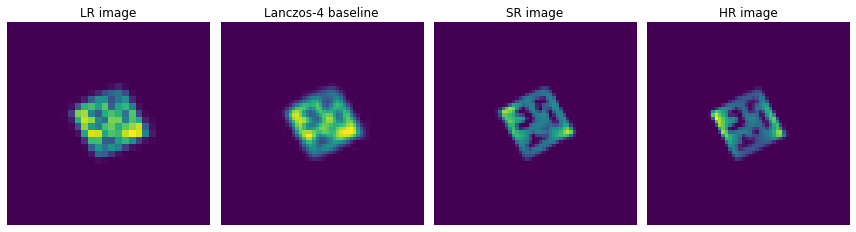

In [129]:
dataset = val_tags_small
sample = np.random.randint(0, dataset.shape[0])
print(sample)
filename = './Figs/test_vis.svg'

def save_row(sample, dataset, filename, threshold=False):
    
    vis_tag_small = dataset.Fill_Blob_small.iloc[sample].reshape(GAN_IN_SHAPE)
    vis_tag_large = dataset.Fill_Blob_large.iloc[sample].reshape(LARGE_SHAPE).astype(np.uint8)
    
    gen_output_tag = generator(tf.convert_to_tensor(vis_tag_small/127.5 - 1.)[tf.newaxis, ...], training=False)
    gen_output_tag = ((gen_output_tag.numpy()[0].reshape(LARGE_SHAPE) + 1) * 127.5).astype(np.uint8)
    
    lanczos_image = tf.cast(tf.image.resize(vis_tag_small, [60,60], method=tf.image.ResizeMethod.LANCZOS3), tf.int32)

    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
                             
    ax[0].imshow(vis_tag_small, vmin = 0, vmax = 255)
    ax[0].set_title("LR image")
    ax[0].set_ylabel("Validation dataset\nAprilTag 36h11")
    ax[0].axis('off')
                             
    ax[1].imshow(lanczos_image, vmin = 0, vmax = 255)
    ax[1].set_title("Lanczos-4 baseline")
    ax[1].axis('off')
    
    if not threshold:
        ax[2].imshow(gen_output_tag, vmin = 0, vmax = 255)
        ax[2].set_title("SR image")
        ax[2].axis('off')

        ax[3].imshow(vis_tag_large, vmin = 0, vmax = 255)
        ax[3].set_title("HR image")
        ax[3].axis('off')
        
    else:
        ax[2].imshow(get_thresholded(gen_output_tag), vmin = 0, vmax = 255)
        ax[2].set_title("SR image thresholded")
        ax[2].axis('off')

        ax[3].imshow(gen_output_tag, vmin = 0, vmax = 255)
        ax[3].set_title("SR image")
        ax[3].axis('off')
    
    fig.tight_layout()
    fig.savefig(filename, format='svg', dpi=120, bbox_inches="tight")
    plt.show()
    
save_row(sample, dataset, filename, threshold=False)